<a href="https://colab.research.google.com/github/Mbigdeli2003/Game-Theory/blob/main/Advanced_Demand_Side_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

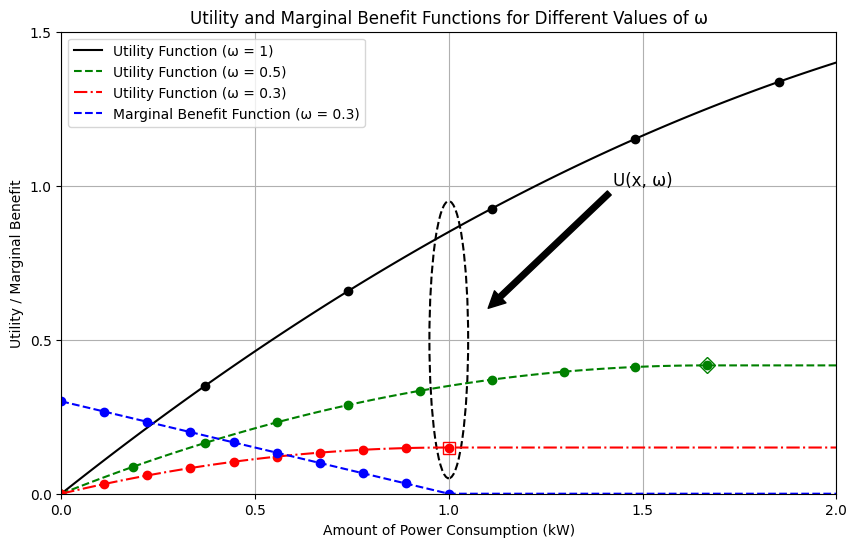

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the utility function
def utility(x, omega, alpha):
    if x < omega / alpha:
        return omega * x - (alpha / 2) * x**2
    else:
        return (omega**2) / (2 * alpha)

# Define the marginal benefit function
def marginal_benefit(x, omega, alpha):
    if x < omega / alpha:
        return omega - alpha * x
    else:
        return 0

# Test the utility function with some values
x_values = np.linspace(0, 2, 100)
omega_values = [1, 0.5, 0.3]
alpha = 0.3

# Plot the utility functions and marginal benefit function
plt.figure(figsize=(10, 6))
colors = ['black', 'green', 'red']
linestyles = ['-', '--', '-.']
markers = ['o', 'D', 's']

for i, omega in enumerate(omega_values):
    U_values = [utility(x, omega, alpha) for x in x_values]
    plt.plot(x_values, U_values, label=f'Utility Function (ω = {omega})', color=colors[i], linestyle=linestyles[i])
    # Calculate the saturation point
    saturation_x = omega / alpha
    saturation_y = utility(saturation_x, omega, alpha)
    # Add a circle at the saturation point
    plt.plot(saturation_x, saturation_y, markers[i], markersize=8, markeredgecolor=colors[i], markerfacecolor='none')
    # Highlight values with dots
    highlight_x = np.linspace(0, saturation_x, 10)
    highlight_y = [utility(x, omega, alpha) for x in highlight_x]
    plt.plot(highlight_x, highlight_y, 'o', color=colors[i])

# Adding the marginal benefit function for ω = 0.3
marginal_values = [marginal_benefit(x, 0.3, alpha) for x in x_values]
plt.plot(x_values, marginal_values, label=f'Marginal Benefit Function (ω = 0.3)', linestyle='--', color='blue')
# Highlight marginal benefit values with dots
highlight_x_marginal = np.linspace(0, 0.3 / alpha, 10)
highlight_y_marginal = [marginal_benefit(x, 0.3, alpha) for x in highlight_x_marginal]
plt.plot(highlight_x_marginal, highlight_y_marginal, 'o', color='blue')

# Adding the ellipse around a specific area
ellipse = patches.Ellipse((1, 0.5), 0.1, 0.9, edgecolor='black', facecolor='none', linestyle='--', linewidth=1.5)
plt.gca().add_patch(ellipse)
# Annotating the ellipse with a label
plt.annotate('U(x, ω)', xy=(1.1, 0.6), xytext=(1.5, 1),
             arrowprops=dict(facecolor='black', shrink=0.005),
             fontsize=12, ha='center')
# Set axis limits and ticks to match Fig. 2
plt.xlim(0, 2)
plt.ylim(0, 1.5)
plt.xticks(np.arange(0, 2.1, 0.5))
plt.yticks(np.arange(0, 1.6, 0.5))

plt.xlabel('Amount of Power Consumption (kW)')
plt.ylabel('Utility / Marginal Benefit')
plt.title('Utility and Marginal Benefit Functions for Different Values of ω')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()


# PLP Method Load consumption

Peak-to-Average Ratio (PAR) for the PLP method: 1.56
Load values for PLP method: [21.38684247 21.38684247 21.38684247 21.38684247 21.38684247 21.38684247
 21.38684247 21.38684247 25.         25.         25.         25.
 25.         25.         25.         25.         50.         50.
 50.         50.         50.         50.         50.         50.        ]


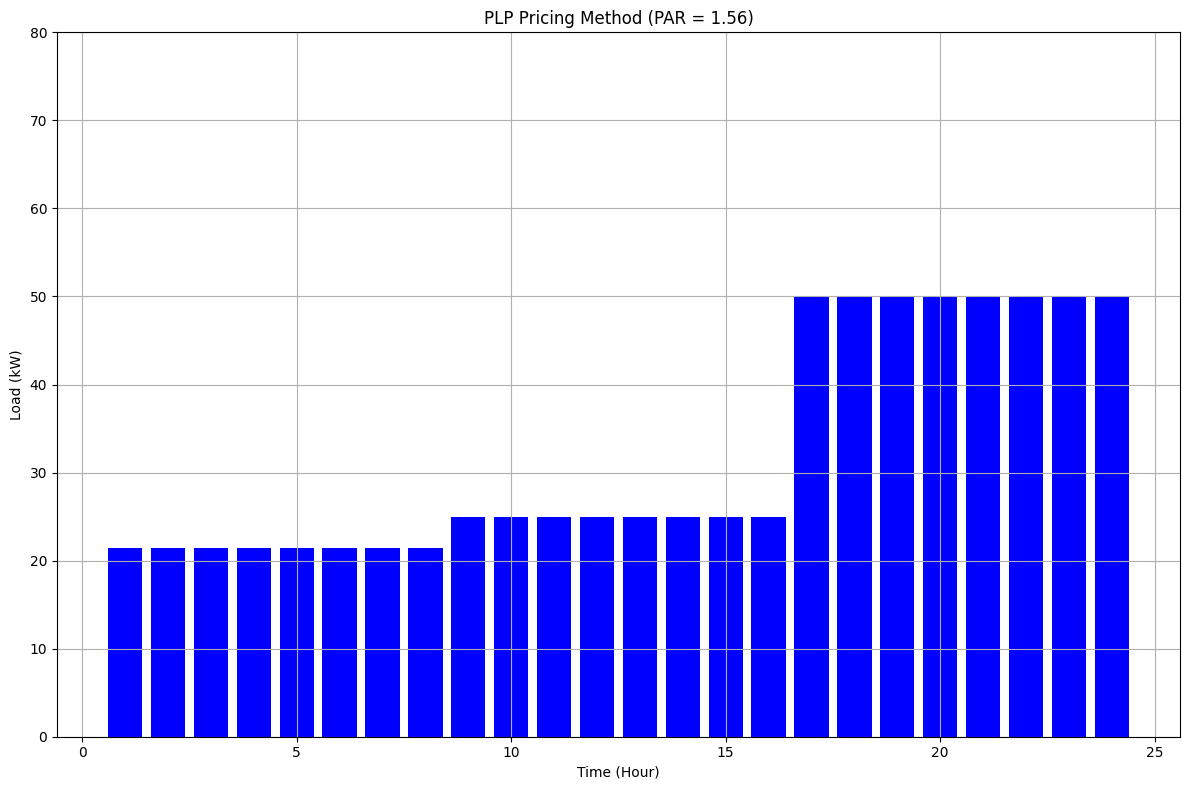

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Parameters
N = 50  # Number of users
K = 24  # Number of time slots
alpha = 0.5

# Define the cost parameters for different periods (off-peak, mid-peak, on-peak)
off_peak_cost = 0.02
mid_peak_cost = 0.3
on_peak_cost = 0.5
a_k = np.array([off_peak_cost] * 8 + [on_peak_cost] * 8 + [mid_peak_cost] * 8)

# Define the minimum power requirements for different periods
off_peak_power = 0.1
mid_peak_power = 0.5
on_peak_power = 1.0
m_k = np.array([off_peak_power] * 8 + [mid_peak_power] * 8 + [on_peak_power] * 8)


# Generate omega values for users with controlled perturbations (uniform distribution)
np.random.seed(0)
omega = np.random.choice(range(5, 16), N) + np.random.uniform(-0.5, 0.5, N)

# Define the utility function
def utility(x, omega, alpha):
    if x < omega / alpha:
        return omega * x - (alpha / 2) * x**2
    else:
        return (omega**2) / (2 * alpha)

# Define the cost function
def cost(L, a):
    return a * L**2

# Initial estimate of average power consumption to set prices
initial_avg_power_consumption = np.linspace(9, 21, K).mean(axis=0)
initial_price_per_kw = initial_avg_power_consumption / N  # Fixed price based on initial estimate

# PLP Method: Calculate the power allocation with fixed initial prices
x_plp = cp.Variable((N, K))  # Power consumption for each user in each time slot

# Define the total load for each time slot
total_load_plp = cp.sum(x_plp, axis=0)

# Define the total revenue for the provider with fixed initial prices
total_revenue_plp = cp.sum(cp.multiply(initial_price_per_kw, total_load_plp))

# Define the total cost for the provider
total_cost_plp = cp.sum([cost(total_load_plp[k], a_k[k]) for k in range(K)])

# Define the objective function to maximize the payoff (revenue - cost)
objective_plp = cp.Maximize(total_revenue_plp - total_cost_plp)

# Constraints for PLP method
constraints_plp = [x_plp >= 0]
for n in range(N):
    constraints_plp.append(cp.sum(x_plp[n, :]) >= np.random.uniform(9, 21))  # Minimum required energy
for k in range(K):
    constraints_plp.append(total_load_plp[k] >= m_k[k] * N)  # Minimum power requirement for each time slot

# Solve the PLP optimization problem
problem_plp = cp.Problem(objective_plp, constraints_plp)
problem_plp.solve()

# Get the optimal power allocation for PLP method
optimal_x_plp = x_plp.value

# Update prices based on the average power consumption after optimization
average_power_consumption = np.mean(optimal_x_plp, axis=0)
price_per_kw = average_power_consumption / N

# Recalculate total revenue with updated prices
total_revenue_plp = np.sum(price_per_kw * np.sum(optimal_x_plp, axis=0))

# Recalculate total cost with updated load
total_cost_plp = np.sum([cost(np.sum(optimal_x_plp[:, k]), a_k[k]) for k in range(K)])

# Calculate the total load for each time slot for PLP method
total_load_plp = np.sum(optimal_x_plp, axis=0)

# Calculate the PAR for the PLP method
peak_load_plp = np.max(total_load_plp)
average_load_plp = np.mean(total_load_plp)
par_plp = peak_load_plp / average_load_plp

# Print the PAR for the PLP method and the total payoff
print(f'Peak-to-Average Ratio (PAR) for the PLP method: {par_plp:.2f}')

# Save the load values for comparison
load_values_plp = total_load_plp
print("Load values for PLP method:", load_values_plp)

# Plot results
time_slots = range(1, K + 1)

plt.figure(figsize=(12, 8))

# Plot PLP method
plt.bar(time_slots, total_load_plp, color='blue')
plt.title(f'PLP Pricing Method (PAR = {par_plp:.2f})')
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.ylim(0, 80)
plt.grid(True)

plt.tight_layout()
plt.show()


# PLP method maximizing payoff of Energy Provider

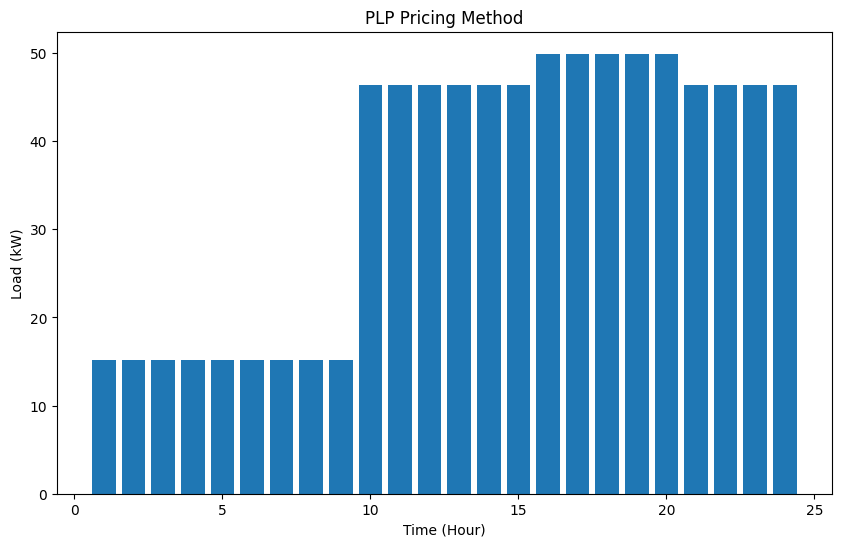

Peak Load: 49.93592703367729 kW
Average Load: 35.41 kW
Peak-to-Average Ratio (PAR): 1.41
Revenue at Hour 1: $4.54
Revenue at Hour 2: $4.54
Revenue at Hour 3: $4.54
Revenue at Hour 4: $4.54
Revenue at Hour 5: $4.54
Revenue at Hour 6: $4.54
Revenue at Hour 7: $4.54
Revenue at Hour 8: $4.54
Revenue at Hour 9: $4.54
Revenue at Hour 10: $23.19
Revenue at Hour 11: $23.19
Revenue at Hour 12: $23.19
Revenue at Hour 13: $23.19
Revenue at Hour 14: $23.19
Revenue at Hour 15: $23.19
Revenue at Hour 16: $29.96
Revenue at Hour 17: $29.96
Revenue at Hour 18: $29.96
Revenue at Hour 19: $29.96
Revenue at Hour 20: $29.96
Revenue at Hour 21: $23.19
Revenue at Hour 22: $23.19
Revenue at Hour 23: $23.19
Revenue at Hour 24: $23.19


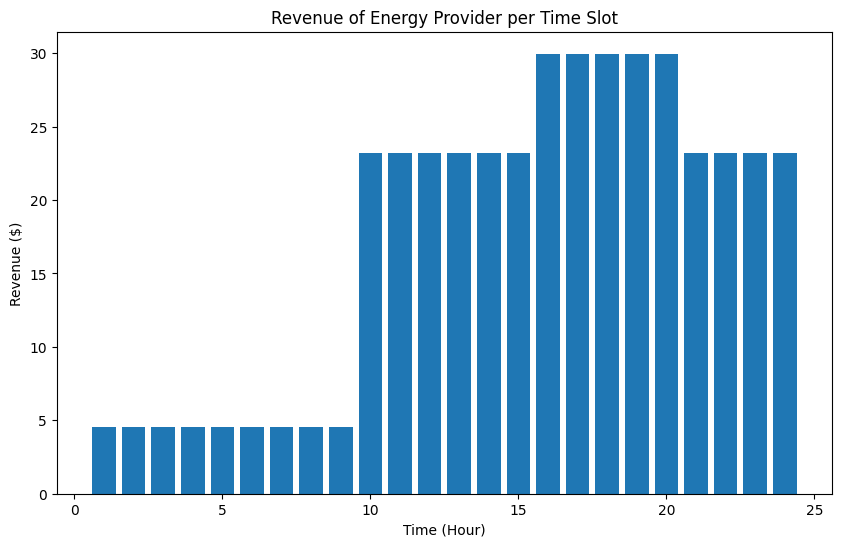

Total Revenue of Energy Provider: $422.59
Total Cost of Energy Provider: $9003.23


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 50
K = 24
omega = np.random.randint(5, 16, size=N) + np.random.normal(0, 0.1, size=N)  # Small perturbations
E_n = np.random.uniform(9, 21, size=N)
m_k_n = np.zeros(K)
time_slots = np.arange(1, K+1)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23,24]
on_peak_hours = [15,16,17, 18, 19]

for k in range(K):
    if k in off_peak_hours:
        m_k_n[k] = 0.1
    elif k in mid_peak_hours:
        m_k_n[k] = 0.5
    else:
        m_k_n[k] = 1.0

# Initialize cost coefficients
a = np.zeros(K)
price_per_unit = np.zeros(K)
for k in range(K):
    if k in off_peak_hours:
        a[k] = 0.02
        price_per_unit[k] = 0.3
    elif k in mid_peak_hours:
        a[k] = 0.3
        price_per_unit[k] = 0.5
    else:
        a[k] = 0.5
        price_per_unit[k] = 0.6

# Utility function
def U(x, omega, alpha=0.5):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Objective function to maximize
def objective(x, omega, a, price_per_unit):
    total_utility = 0
    total_cost = 0
    total_revenue = 0
    x = x.reshape(N, K)

    # Calculate total utility for all users
    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    # Calculate total cost and total revenue for the provider
    for k in range(K):
        total_cost += C(np.sum(x[:, k]), a[k])
        total_revenue += np.sum(x[:, k]) * price_per_unit[k]

    # Calculate provider's payoff
    provider_payoff = total_revenue - total_cost

    # Maximize the provider's payoff while also considering user utility
    return -(provider_payoff)

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k_n[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(10, 60, N * K)

# Constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Run the optimization
solution = minimize(objective, x0, args=(omega, a, price_per_unit), method='SLSQP', constraints=constraints)
x_opt = solution.x.reshape(N, K)

# Plot the results
plt.figure(figsize=(10, 6))
total_load = np.sum(x_opt, axis=0)
plt.bar(time_slots, total_load)
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('PLP Pricing Method')
plt.show()

# Calculate Peak-to-Average Ratio (PAR)
peak_load = np.max(total_load)
average_load = np.mean(total_load)
par = peak_load / average_load

print(f"Peak Load: {peak_load} kW")
print(f"Average Load: {average_load:.2f} kW")
print(f"Peak-to-Average Ratio (PAR): {par:.2f}")

# Calculate Revenue for Each Time Slot
revenue_per_slot = total_load * price_per_unit

# Print Revenue for Each Time Slot
for k in range(K):
    print(f"Revenue at Hour {k+1}: ${revenue_per_slot[k]:.2f}")

# Plot Revenue for Each Time Slot
plt.figure(figsize=(10, 6))
plt.bar(time_slots, revenue_per_slot)
plt.xlabel('Time (Hour)')
plt.ylabel('Revenue ($)')
plt.title('Revenue of Energy Provider per Time Slot')
plt.show()

# Calculate total revenue and provider payoff
total_revenue = np.sum(revenue_per_slot)
total_cost = np.sum([C(np.sum(x_opt[:, k]), a[k]) for k in range(K)])
provider_payoff = total_revenue - total_cost

print(f"Total Revenue of Energy Provider: ${total_revenue:.2f}")
print(f"Total Cost of Energy Provider: ${total_cost:.2f}")


# PLP method maximizing payoff of Energy Provider +Utitily function

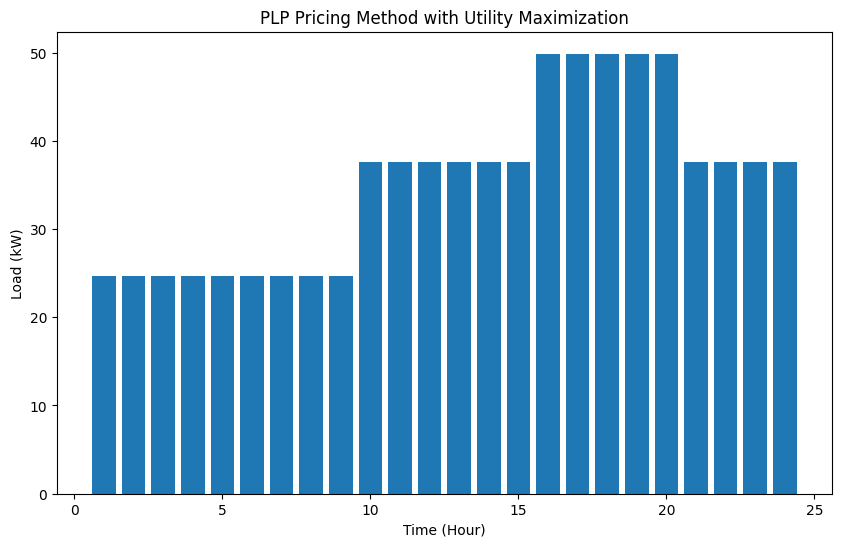

Peak Load: 49.867770179386525 kW
Average Load: 35.29 kW
Peak-to-Average Ratio (PAR): 1.41
Revenue at Hour 1: $7.41
Revenue at Hour 2: $7.41
Revenue at Hour 3: $7.41
Revenue at Hour 4: $7.41
Revenue at Hour 5: $7.41
Revenue at Hour 6: $7.41
Revenue at Hour 7: $7.41
Revenue at Hour 8: $7.41
Revenue at Hour 9: $7.41
Revenue at Hour 10: $18.77
Revenue at Hour 11: $18.77
Revenue at Hour 12: $18.77
Revenue at Hour 13: $18.77
Revenue at Hour 14: $18.77
Revenue at Hour 15: $18.77
Revenue at Hour 16: $29.91
Revenue at Hour 17: $29.91
Revenue at Hour 18: $29.92
Revenue at Hour 19: $29.91
Revenue at Hour 20: $29.92
Revenue at Hour 21: $18.77
Revenue at Hour 22: $18.77
Revenue at Hour 23: $18.77
Revenue at Hour 24: $18.77


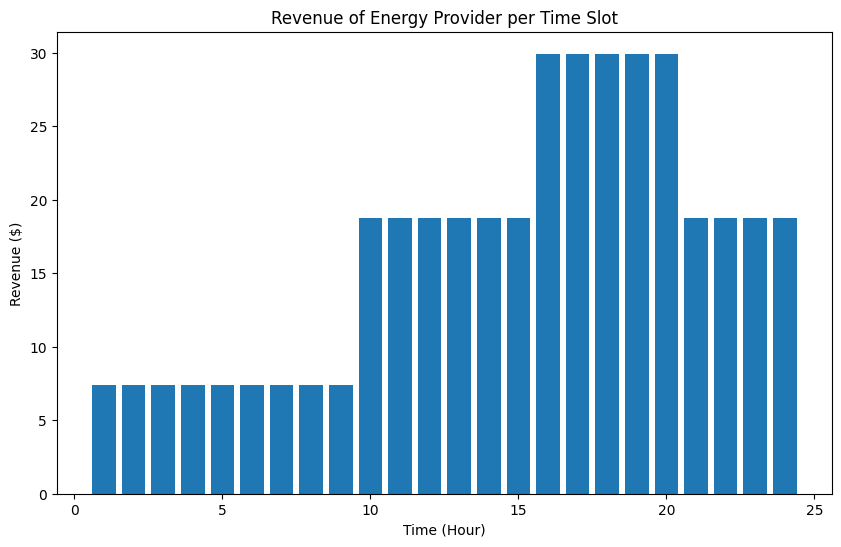

Total Revenue of Energy Provider: $403.96
Total Cost of Energy Provider: $10680.28


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 50
K = 24
omega = np.random.randint(5, 16, size=N) + np.random.normal(0, 0.1, size=N)  # Small perturbations
E_n = np.random.uniform(9, 21, size=N)
m_k_n = np.zeros(K)
time_slots = np.arange(1, K+1)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23,24]
on_peak_hours = [15,16,17, 18, 19]


for k in range(K):
    if k in off_peak_hours:
        m_k_n[k] = 0.1
    elif k in mid_peak_hours:
        m_k_n[k] = 0.5
    else:
        m_k_n[k] = 1.0

# Initialize cost coefficients
a = np.zeros(K)
price_per_unit = np.zeros(K)
for k in range(K):
    if k in off_peak_hours:
        a[k] = 0.3
        price_per_unit[k] = 0.3
    elif k in mid_peak_hours:
        a[k] = 0.2
        price_per_unit[k] = 0.5
    else:
        a[k] = 0.5
        price_per_unit[k] = 0.6

# Utility function
def U(x, omega, alpha=0.5):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Objective function to maximize
def objective(x, omega, a, price_per_unit):
    total_utility = 0
    total_cost = 0
    total_revenue = 0
    x = x.reshape(N, K)

    # Calculate total utility for all users
    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    # Calculate total cost and total revenue for the provider
    for k in range(K):
        total_cost += C(np.sum(x[:, k]), a[k])
        total_revenue += np.sum(x[:, k]) * price_per_unit[k]

    # Calculate provider's payoff
    provider_payoff = total_revenue - total_cost

    # Maximize the provider's payoff while also considering user utility
    return -(total_utility+provider_payoff)

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k_n[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(10, 60, N * K)

# Constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Run the optimization
solution = minimize(objective, x0, args=(omega, a, price_per_unit), method='SLSQP', constraints=constraints)
x_opt = solution.x.reshape(N, K)

# Plot the results
plt.figure(figsize=(10, 6))
total_load = np.sum(x_opt, axis=0)
plt.bar(time_slots, total_load)
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('PLP Pricing Method with Utility Maximization')
plt.show()

# Calculate Peak-to-Average Ratio (PAR)
peak_load = np.max(total_load)
average_load = np.mean(total_load)
par = peak_load / average_load

print(f"Peak Load: {peak_load} kW")
print(f"Average Load: {average_load:.2f} kW")
print(f"Peak-to-Average Ratio (PAR): {par:.2f}")

# Calculate Revenue for Each Time Slot
revenue_per_slot = total_load * price_per_unit

# Print Revenue for Each Time Slot
for k in range(K):
    print(f"Revenue at Hour {k+1}: ${revenue_per_slot[k]:.2f}")

# Plot Revenue for Each Time Slot
plt.figure(figsize=(10, 6))
plt.bar(time_slots, revenue_per_slot)
plt.xlabel('Time (Hour)')
plt.ylabel('Revenue ($)')
plt.title('Revenue of Energy Provider per Time Slot')
plt.show()

# Calculate total revenue and provider payoff
total_revenue = np.sum(revenue_per_slot)
total_cost = np.sum([C(np.sum(x_opt[:, k]), a[k]) for k in range(K)])
provider_payoff = total_revenue - total_cost

print(f"Total Revenue of Energy Provider: ${total_revenue:.2f}")
print(f"Total Cost of Energy Provider: ${total_cost:.2f}")


#PLP method maximizing payoff+utlity of energy provider with dynamic pricing

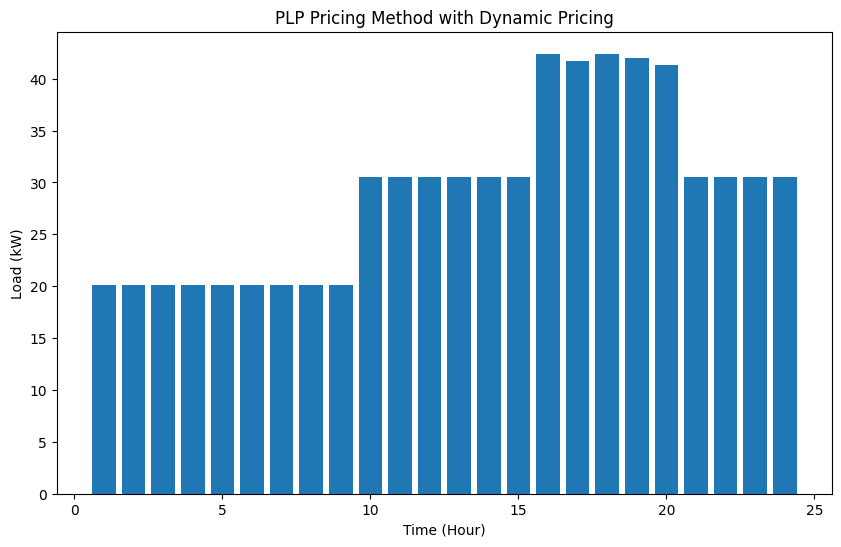

Peak Load: 42.39949241902081 kW
Average Load: 29.02 kW
Peak-to-Average Ratio (PAR): 1.46
Revenue at Hour 1: $3.15
Revenue at Hour 2: $3.15
Revenue at Hour 3: $3.15
Revenue at Hour 4: $3.15
Revenue at Hour 5: $3.15
Revenue at Hour 6: $3.15
Revenue at Hour 7: $3.15
Revenue at Hour 8: $3.15
Revenue at Hour 9: $3.15
Revenue at Hour 10: $6.79
Revenue at Hour 11: $6.79
Revenue at Hour 12: $6.79
Revenue at Hour 13: $6.79
Revenue at Hour 14: $6.79
Revenue at Hour 15: $6.79
Revenue at Hour 16: $13.59
Revenue at Hour 17: $13.21
Revenue at Hour 18: $13.58
Revenue at Hour 19: $13.39
Revenue at Hour 20: $13.01
Revenue at Hour 21: $6.79
Revenue at Hour 22: $6.79
Revenue at Hour 23: $6.79
Revenue at Hour 24: $6.79


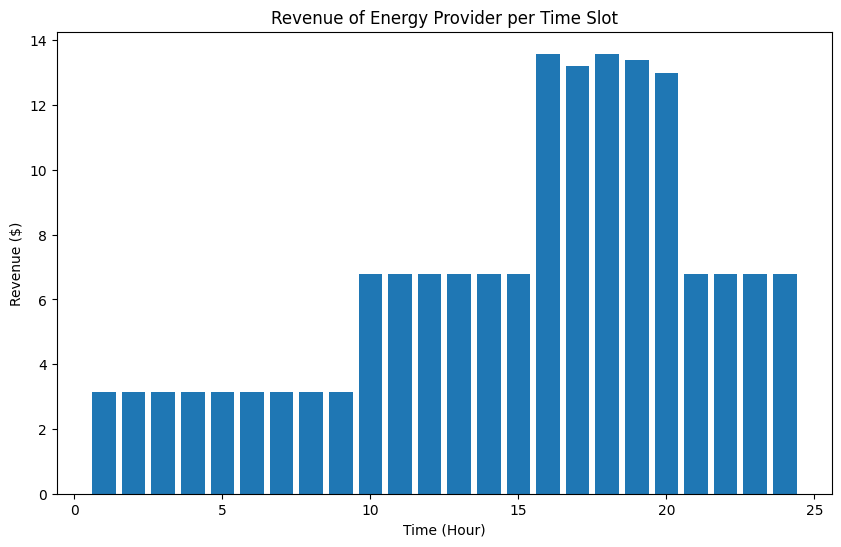

Total Revenue of Energy Provider: $162.98
Total Cost of Energy Provider: $7364.06


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 50  # Number of users
K = 24  # Number of time slots
omega = np.random.randint(5, 16, size=N) + np.random.normal(0, 0.1, size=N)  # User-specific parameter with small perturbations
E_n = np.random.uniform(9, 21, size=N)  # Energy requirements for each user
m_k_n = np.zeros(K)
time_slots = np.arange(1, K+1)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24]
on_peak_hours = [15, 16, 17, 18, 19]

# Set minimum power requirements for each time slot
for k in range(K):
    if k in off_peak_hours:
        m_k_n[k] = 0.1
    elif k in mid_peak_hours:
        m_k_n[k] = 0.5
    else:
        m_k_n[k] = 1.0

# Initialize cost coefficients
a = np.zeros(K)
for k in range(K):
    if k in off_peak_hours:
        a[k] = 0.3
    elif k in mid_peak_hours:
        a[k] = 0.2
    else:
        a[k] = 0.5

# Utility function
def U(x, omega, alpha=0.3):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Dynamic pricing function based on peak hours
def price_per_unit(k, avg_power_consumption, base_price=0.1, multiplier=0.2):
    if k in off_peak_hours:
        return base_price + multiplier * avg_power_consumption * 0.7  # Dynamic pricing for off-peak hours
    elif k in mid_peak_hours:
        return base_price + multiplier * avg_power_consumption  # Dynamic pricing for mid-peak hours
    else:
        return base_price + multiplier * avg_power_consumption * 1.3  # Dynamic pricing for on-peak hours

# Objective function to maximize
def objective(x, omega, a):
    x = x.reshape(N, K)
    total_utility = 0
    total_cost = 0
    total_revenue = 0

    # Calculate total utility for all users
    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    # Calculate total cost and total revenue for the provider
    for k in range(K):
        avg_power_consumption = np.mean(x[:, k])
        price_k = price_per_unit(k, avg_power_consumption)
        total_cost += C(np.sum(x[:, k]), a[k])
        total_revenue += np.sum(x[:, k]) * price_k

    # Calculate provider's payoff
    provider_payoff = total_revenue - total_cost

    # Maximize the provider's payoff while also considering user utility
    return -(provider_payoff + total_utility)

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k_n[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(0, 1, N * K)

# Constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Run the optimization
solution = minimize(objective, x0, args=(omega, a), method='SLSQP', constraints=constraints)
x_opt = solution.x.reshape(N, K)

# Plot the results
plt.figure(figsize=(10, 6))
total_load = np.sum(x_opt, axis=0)
plt.bar(time_slots, total_load)
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('PLP Pricing Method with Dynamic Pricing')
plt.show()

# Calculate Peak-to-Average Ratio (PAR)
peak_load = np.max(total_load)
average_load = np.mean(total_load)
par = peak_load / average_load

print(f"Peak Load: {peak_load} kW")
print(f"Average Load: {average_load:.2f} kW")
print(f"Peak-to-Average Ratio (PAR): {par:.2f}")

# Calculate Revenue for Each Time Slot using the optimized power values
revenue_per_slot = np.zeros(K)
for k in range(K):
    avg_power_consumption = np.mean(x_opt[:, k])
    price_k = price_per_unit(k, avg_power_consumption)
    revenue_per_slot[k] = np.sum(x_opt[:, k]) * price_k

# Print Revenue for Each Time Slot
for k in range(K):
    print(f"Revenue at Hour {k+1}: ${revenue_per_slot[k]:.2f}")

# Plot Revenue for Each Time Slot
plt.figure(figsize=(10, 6))
plt.bar(time_slots, revenue_per_slot)
plt.xlabel('Time (Hour)')
plt.ylabel('Revenue ($)')
plt.title('Revenue of Energy Provider per Time Slot')
plt.show()

# Calculate total revenue and provider payoff
total_revenue = np.sum(revenue_per_slot)
total_cost = np.sum([C(np.sum(x_opt[:, k]), a[k]) for k in range(K)])
provider_payoff = total_revenue - total_cost

print(f"Total Revenue of Energy Provider: ${total_revenue:.2f}")
print(f"Total Cost of Energy Provider: ${total_cost:.2f}")



# provider pay off

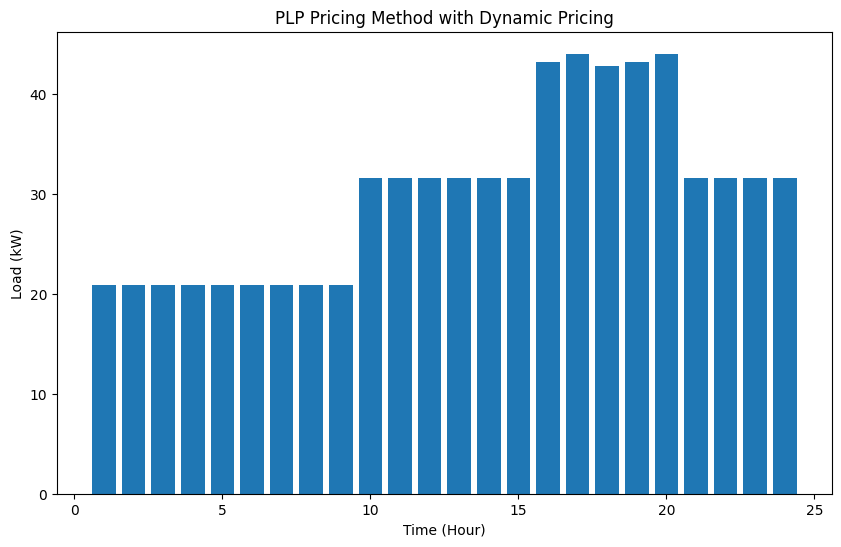

Peak Load: 43.975870097864 kW
Average Load: 30.01 kW
Peak-to-Average Ratio (PAR): 1.47
Revenue at Hour 1: $3.30
Revenue at Hour 2: $3.30
Revenue at Hour 3: $3.30
Revenue at Hour 4: $3.30
Revenue at Hour 5: $3.30
Revenue at Hour 6: $3.30
Revenue at Hour 7: $3.30
Revenue at Hour 8: $3.30
Revenue at Hour 9: $3.30
Revenue at Hour 10: $7.15
Revenue at Hour 11: $7.15
Revenue at Hour 12: $7.15
Revenue at Hour 13: $7.15
Revenue at Hour 14: $7.15
Revenue at Hour 15: $7.15
Revenue at Hour 16: $14.01
Revenue at Hour 17: $14.43
Revenue at Hour 18: $13.78
Revenue at Hour 19: $14.01
Revenue at Hour 20: $14.45
Revenue at Hour 21: $7.15
Revenue at Hour 22: $7.15
Revenue at Hour 23: $7.15
Revenue at Hour 24: $7.15


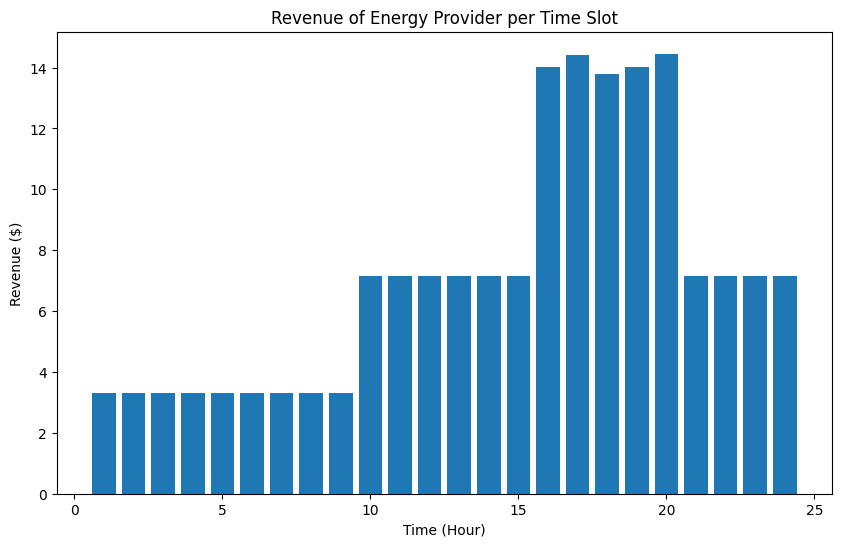

Total Revenue of Energy Provider: $171.82
Total Cost of Energy Provider: $7875.58


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 50  # Number of users
K = 24  # Number of time slots
omega = np.random.randint(5, 16, size=N) + np.random.normal(0, 0.1, size=N)  # User-specific parameter with small perturbations
E_n = np.random.uniform(9, 21, size=N)  # Energy requirements for each user
m_k_n = np.zeros(K)
time_slots = np.arange(1, K+1)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24]
on_peak_hours = [15, 16, 17, 18, 19]

# Set minimum power requirements for each time slot
for k in range(K):
    if k in off_peak_hours:
        m_k_n[k] = 0.1
    elif k in mid_peak_hours:
        m_k_n[k] = 0.5
    else:
        m_k_n[k] = 1.0

# Initialize cost coefficients
a = np.zeros(K)
for k in range(K):
    if k in off_peak_hours:
        a[k] = 0.3
    elif k in mid_peak_hours:
        a[k] = 0.2
    else:
        a[k] = 0.5

# Utility function
def U(x, omega, alpha=0.3):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Dynamic pricing function based on peak hours
def price_per_unit(k, avg_power_consumption, base_price=0.1, multiplier=0.2):
    if k in off_peak_hours:
        return base_price + multiplier * avg_power_consumption * 0.7  # Dynamic pricing for off-peak hours
    elif k in mid_peak_hours:
        return base_price + multiplier * avg_power_consumption  # Dynamic pricing for mid-peak hours
    else:
        return base_price + multiplier * avg_power_consumption * 1.3  # Dynamic pricing for on-peak hours

# Objective function to maximize
def objective(x, omega, a):
    x = x.reshape(N, K)
    total_utility = 0
    total_cost = 0
    total_revenue = 0

    # Calculate total utility for all users
    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    # Calculate total cost and total revenue for the provider
    for k in range(K):
        avg_power_consumption = np.mean(x[:, k])
        price_k = price_per_unit(k, avg_power_consumption)
        total_cost += C(np.sum(x[:, k]), a[k])
        total_revenue += np.sum(x[:, k]) * price_k

    # Calculate provider's payoff
    provider_payoff = total_revenue - total_cost

    # Maximize the provider's payoff while also considering user utility
    return -(provider_payoff)

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k_n[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(0, 1, N * K)

# Constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Run the optimization
solution = minimize(objective, x0, args=(omega, a), method='SLSQP', constraints=constraints)
x_opt = solution.x.reshape(N, K)

# Plot the results
plt.figure(figsize=(10, 6))
total_load = np.sum(x_opt, axis=0)
plt.bar(time_slots, total_load)
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('PLP Pricing Method with Dynamic Pricing')
plt.show()

# Calculate Peak-to-Average Ratio (PAR)
peak_load = np.max(total_load)
average_load = np.mean(total_load)
par = peak_load / average_load

print(f"Peak Load: {peak_load} kW")
print(f"Average Load: {average_load:.2f} kW")
print(f"Peak-to-Average Ratio (PAR): {par:.2f}")

# Calculate Revenue for Each Time Slot using the optimized power values
revenue_per_slot = np.zeros(K)
for k in range(K):
    avg_power_consumption = np.mean(x_opt[:, k])
    price_k = price_per_unit(k, avg_power_consumption)
    revenue_per_slot[k] = np.sum(x_opt[:, k]) * price_k

# Print Revenue for Each Time Slot
for k in range(K):
    print(f"Revenue at Hour {k+1}: ${revenue_per_slot[k]:.2f}")

# Plot Revenue for Each Time Slot
plt.figure(figsize=(10, 6))
plt.bar(time_slots, revenue_per_slot)
plt.xlabel('Time (Hour)')
plt.ylabel('Revenue ($)')
plt.title('Revenue of Energy Provider per Time Slot')
plt.show()

# Calculate total revenue and provider payoff
total_revenue = np.sum(revenue_per_slot)
total_cost = np.sum([C(np.sum(x_opt[:, k]), a[k]) for k in range(K)])
provider_payoff = total_revenue - total_cost

print(f"Total Revenue of Energy Provider: ${total_revenue:.2f}")
print(f"Total Cost of Energy Provider: ${total_cost:.2f}")



# VCG

# VCG fixed pricing

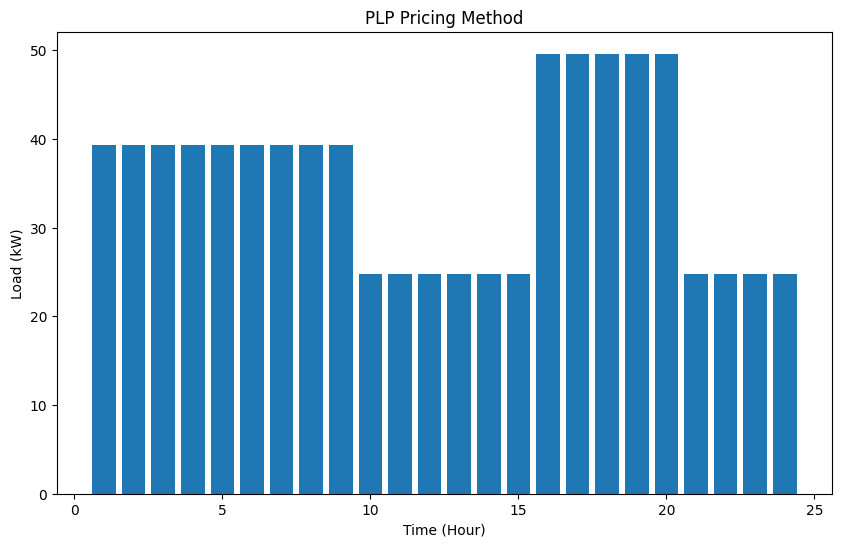

Peak Load: 49.587157496269725 kW
Average Load: 35.36 kW
Peak-to-Average Ratio (PAR): 1.40
Revenue at Hour 1: $11.78
Revenue at Hour 2: $11.78
Revenue at Hour 3: $11.79
Revenue at Hour 4: $11.78
Revenue at Hour 5: $11.78
Revenue at Hour 6: $11.78
Revenue at Hour 7: $11.79
Revenue at Hour 8: $11.79
Revenue at Hour 9: $11.79
Revenue at Hour 10: $12.37
Revenue at Hour 11: $12.37
Revenue at Hour 12: $12.37
Revenue at Hour 13: $12.36
Revenue at Hour 14: $12.37
Revenue at Hour 15: $12.37
Revenue at Hour 16: $29.75
Revenue at Hour 17: $29.73
Revenue at Hour 18: $29.75
Revenue at Hour 19: $29.74
Revenue at Hour 20: $29.73
Revenue at Hour 21: $12.37
Revenue at Hour 22: $12.38
Revenue at Hour 23: $12.36
Revenue at Hour 24: $12.38


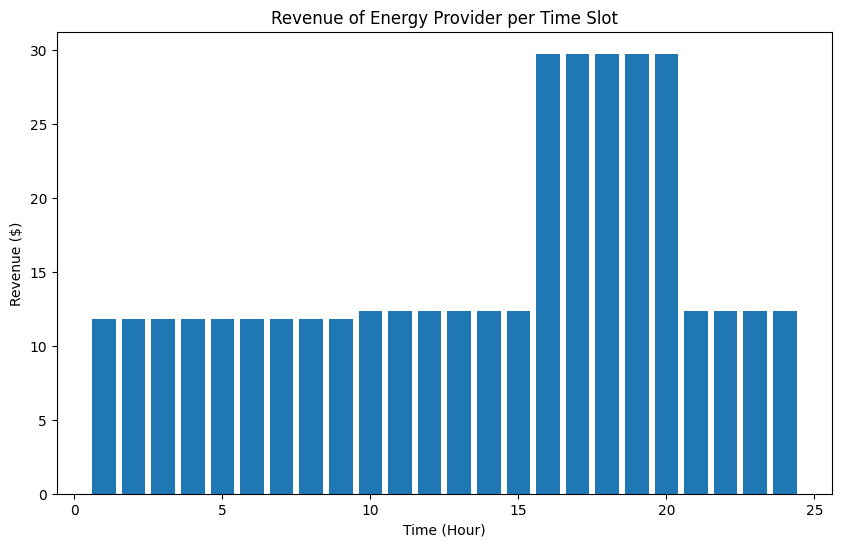

Total Revenue of Energy Provider: $378.45
Total Cost of Energy Provider: $8255.50


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 50
K = 24
omega = np.random.randint(5, 16, size=N) + np.random.normal(0, 0.1, size=N)  # Small perturbations
E_n = np.random.uniform(9, 21, size=N)
m_k_n = np.zeros(K)
time_slots = np.arange(1, K+1)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23,24]
on_peak_hours = [15,16,17, 18, 19]

for k in range(K):
    if k in off_peak_hours:
        m_k_n[k] = 0.1
    elif k in mid_peak_hours:
        m_k_n[k] = 0.5
    else:
        m_k_n[k] = 1.0

# Initialize cost coefficients
a = np.zeros(K)
price_per_unit = np.zeros(K)
for k in range(K):
    if k in off_peak_hours:
        a[k] = 0.02
        price_per_unit[k] = 0.3
    elif k in mid_peak_hours:
        a[k] = 0.3
        price_per_unit[k] = 0.5
    else:
        a[k] = 0.5
        price_per_unit[k] = 0.6

# Utility function
def U(x, omega, alpha=0.5):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Objective function to maximize
def objective(x, omega, a, price_per_unit):
    total_utility = 0
    total_cost = 0
    total_revenue = 0
    x = x.reshape(N, K)

    # Calculate total utility for all users
    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    # Calculate total cost and total revenue for the provider
    for k in range(K):
        total_cost += C(np.sum(x[:, k]), a[k])
        total_revenue += np.sum(x[:, k]) * price_per_unit[k]

    # Calculate provider's payoff
    provider_payoff = total_revenue - total_cost

    # Maximize the provider's payoff while also considering user utility
    return -(total_utility- total_cost)

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k_n[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(10, 60, N * K)

# Constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Run the optimization
solution = minimize(objective, x0, args=(omega, a, price_per_unit), method='SLSQP', constraints=constraints)
x_opt = solution.x.reshape(N, K)

# Plot the results
plt.figure(figsize=(10, 6))
total_load = np.sum(x_opt, axis=0)
plt.bar(time_slots, total_load)
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('VCG Pricing Method')
plt.show()

# Calculate Peak-to-Average Ratio (PAR)
peak_load = np.max(total_load)
average_load = np.mean(total_load)
par = peak_load / average_load

print(f"Peak Load: {peak_load} kW")
print(f"Average Load: {average_load:.2f} kW")
print(f"Peak-to-Average Ratio (PAR): {par:.2f}")

# Calculate Revenue for Each Time Slot
revenue_per_slot = total_load * price_per_unit

# Print Revenue for Each Time Slot
for k in range(K):
    print(f"Revenue at Hour {k+1}: ${revenue_per_slot[k]:.2f}")

# Plot Revenue for Each Time Slot
plt.figure(figsize=(10, 6))
plt.bar(time_slots, revenue_per_slot)
plt.xlabel('Time (Hour)')
plt.ylabel('Revenue ($)')
plt.title('Revenue of Energy Provider per Time Slot')
plt.show()

# Calculate total revenue and provider payoff
total_revenue = np.sum(revenue_per_slot)
total_cost = np.sum([C(np.sum(x_opt[:, k]), a[k]) for k in range(K)])
provider_payoff = total_revenue - total_cost

print(f"Total Revenue of Energy Provider: ${total_revenue:.2f}")
print(f"Total Cost of Energy Provider: ${total_cost:.2f}")


# VCG Dynamic Pricing

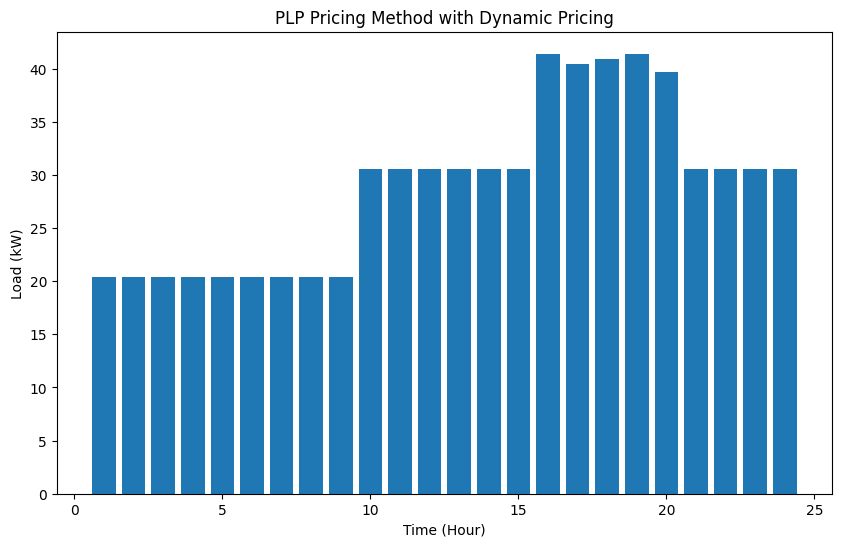

Peak Load: 41.39111556965333 kW
Average Load: 28.88 kW
Peak-to-Average Ratio (PAR): 1.43
Revenue at Hour 1: $3.20
Revenue at Hour 2: $3.20
Revenue at Hour 3: $3.20
Revenue at Hour 4: $3.20
Revenue at Hour 5: $3.20
Revenue at Hour 6: $3.20
Revenue at Hour 7: $3.20
Revenue at Hour 8: $3.20
Revenue at Hour 9: $3.20
Revenue at Hour 10: $6.80
Revenue at Hour 11: $6.80
Revenue at Hour 12: $6.80
Revenue at Hour 13: $6.80
Revenue at Hour 14: $6.80
Revenue at Hour 15: $6.80
Revenue at Hour 16: $13.03
Revenue at Hour 17: $12.54
Revenue at Hour 18: $12.81
Revenue at Hour 19: $13.05
Revenue at Hour 20: $12.13
Revenue at Hour 21: $6.80
Revenue at Hour 22: $6.80
Revenue at Hour 23: $6.80
Revenue at Hour 24: $6.80


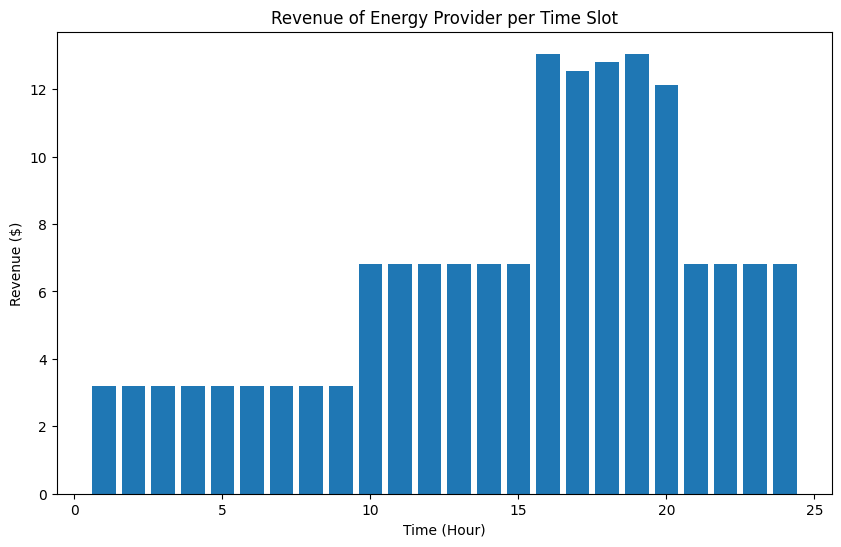

Total Revenue of Energy Provider: $160.37
Total Cost of Energy Provider: $7144.98


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 50  # Number of users
K = 24  # Number of time slots
omega = np.random.randint(5, 16, size=N) + np.random.normal(0, 0.1, size=N)  # User-specific parameter with small perturbations
E_n = np.random.uniform(9, 21, size=N)  # Energy requirements for each user
m_k_n = np.zeros(K)
time_slots = np.arange(1, K+1)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24]
on_peak_hours = [15, 16, 17, 18, 19]

# Set minimum power requirements for each time slot
for k in range(K):
    if k in off_peak_hours:
        m_k_n[k] = 0.1
    elif k in mid_peak_hours:
        m_k_n[k] = 0.5
    else:
        m_k_n[k] = 1.0

# Initialize cost coefficients
a = np.zeros(K)
for k in range(K):
    if k in off_peak_hours:
        a[k] = 0.3
    elif k in mid_peak_hours:
        a[k] = 0.2
    else:
        a[k] = 0.5

# Utility function
def U(x, omega, alpha=0.3):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Dynamic pricing function based on peak hours
def price_per_unit(k, avg_power_consumption, base_price=0.1, multiplier=0.2):
    if k in off_peak_hours:
        return base_price + multiplier * avg_power_consumption * 0.7  # Dynamic pricing for off-peak hours
    elif k in mid_peak_hours:
        return base_price + multiplier * avg_power_consumption  # Dynamic pricing for mid-peak hours
    else:
        return base_price + multiplier * avg_power_consumption * 1.3  # Dynamic pricing for on-peak hours

# Objective function to maximize
def objective(x, omega, a):
    x = x.reshape(N, K)
    total_utility = 0
    total_cost = 0
    total_revenue = 0

    # Calculate total utility for all users
    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    # Calculate total cost and total revenue for the provider
    for k in range(K):
        avg_power_consumption = np.mean(x[:, k])
        price_k = price_per_unit(k, avg_power_consumption)
        total_cost += C(np.sum(x[:, k]), a[k])
        total_revenue += np.sum(x[:, k]) * price_k

    # Calculate provider's payoff
    provider_payoff = total_revenue - total_cost

    # Maximize the provider's payoff while also considering user utility
    return -(total_utility- total_cost)

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k_n[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(0, 1, N * K)

# Constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Run the optimization
solution = minimize(objective, x0, args=(omega, a), method='SLSQP', constraints=constraints)
x_opt = solution.x.reshape(N, K)

# Plot the results
plt.figure(figsize=(10, 6))
total_load = np.sum(x_opt, axis=0)
plt.bar(time_slots, total_load)
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('VCG Pricing Method with Dynamic Pricing')
plt.show()

# Calculate Peak-to-Average Ratio (PAR)
peak_load = np.max(total_load)
average_load = np.mean(total_load)
par = peak_load / average_load

print(f"Peak Load: {peak_load} kW")
print(f"Average Load: {average_load:.2f} kW")
print(f"Peak-to-Average Ratio (PAR): {par:.2f}")

# Calculate Revenue for Each Time Slot using the optimized power values
revenue_per_slot = np.zeros(K)
for k in range(K):
    avg_power_consumption = np.mean(x_opt[:, k])
    price_k = price_per_unit(k, avg_power_consumption)
    revenue_per_slot[k] = np.sum(x_opt[:, k]) * price_k

# Print Revenue for Each Time Slot
for k in range(K):
    print(f"Revenue at Hour {k+1}: ${revenue_per_slot[k]:.2f}")

# Plot Revenue for Each Time Slot
plt.figure(figsize=(10, 6))
plt.bar(time_slots, revenue_per_slot)
plt.xlabel('Time (Hour)')
plt.ylabel('Revenue ($)')
plt.title('Revenue of Energy Provider per Time Slot')
plt.show()

# Calculate total revenue and provider payoff
total_revenue = np.sum(revenue_per_slot)
total_cost = np.sum([C(np.sum(x_opt[:, k]), a[k]) for k in range(K)])
provider_payoff = total_revenue - total_cost

print(f"Total Revenue of Energy Provider: ${total_revenue:.2f}")
print(f"Total Cost of Energy Provider: ${total_cost:.2f}")



#Avarage Power consumption

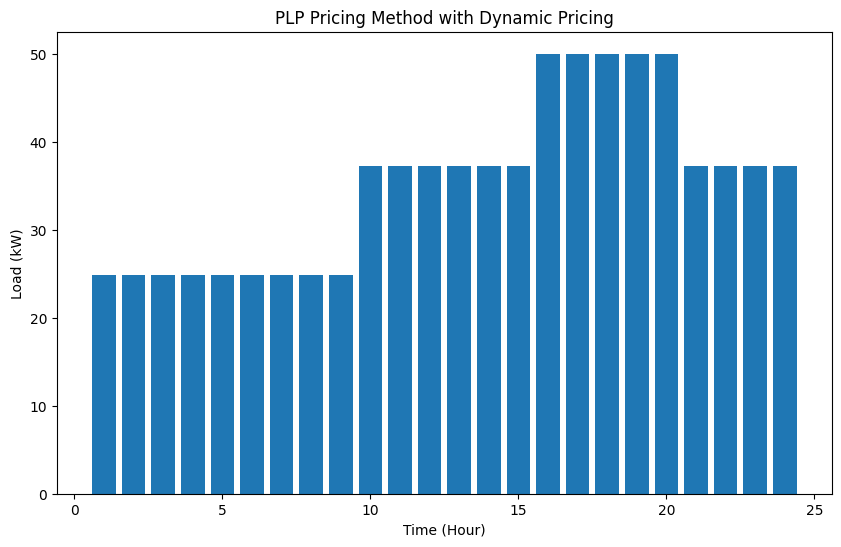

Peak Load: 49.99999950105251 kW
Average Load: 35.28 kW
Peak-to-Average Ratio (PAR): 1.42
Revenue at Hour 1: $12.36
Revenue at Hour 2: $12.36
Revenue at Hour 3: $12.36
Revenue at Hour 4: $12.36
Revenue at Hour 5: $12.36
Revenue at Hour 6: $12.36
Revenue at Hour 7: $12.36
Revenue at Hour 8: $12.36
Revenue at Hour 9: $12.36
Revenue at Hour 10: $27.81
Revenue at Hour 11: $27.81
Revenue at Hour 12: $27.81
Revenue at Hour 13: $27.81
Revenue at Hour 14: $27.81
Revenue at Hour 15: $27.81
Revenue at Hour 16: $50.00
Revenue at Hour 17: $50.00
Revenue at Hour 18: $50.00
Revenue at Hour 19: $50.00
Revenue at Hour 20: $50.00
Revenue at Hour 21: $27.81
Revenue at Hour 22: $27.81
Revenue at Hour 23: $27.81
Revenue at Hour 24: $27.81


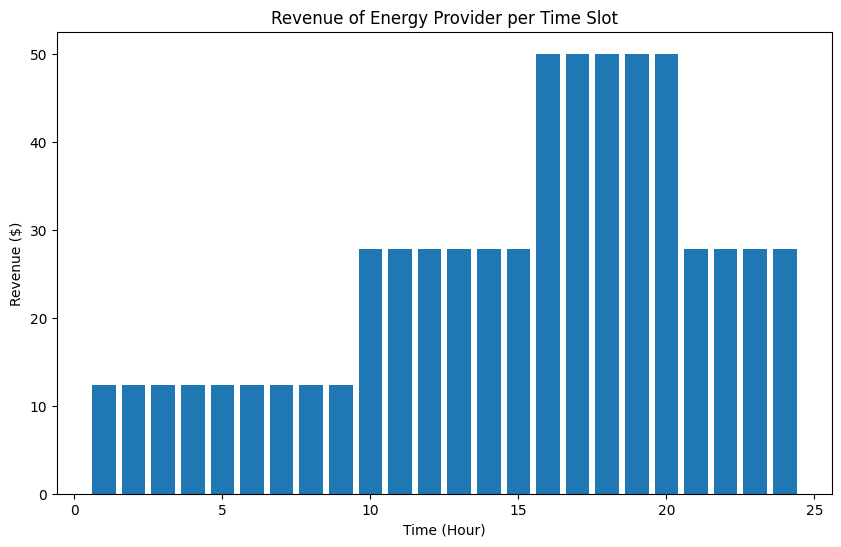

Total Revenue of Energy Provider: $639.36
Total Cost of Energy Provider: $10699.81


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 50  # Number of users
K = 24  # Number of time slots
omega = np.random.randint(5, 16, size=N) + np.random.normal(0, 0.1, size=N)  # User-specific parameter with small perturbations
E_n = np.random.uniform(9, 21, size=N)  # Energy requirements for each user
m_k_n = np.zeros(K)
time_slots = np.arange(1, K+1)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23,24]
on_peak_hours = [15,16,17, 18, 19]

# off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# mid_peak_hours = [17, 18, 19, 20, 21, 22, 23, 24 ]
# on_peak_hours = [9,10, 11, 12,13,14,15,16]

# Set minimum power requirements for each time slot
for k in range(K):
    if k in off_peak_hours:
        m_k_n[k] = 0.1
    elif k in mid_peak_hours:
        m_k_n[k] = 0.5
    else:
        m_k_n[k] = 1.0

# Initialize cost coefficients
a = np.zeros(K)
for k in range(K):
    if k in off_peak_hours:
        a[k] = 0.3
    elif k in mid_peak_hours:
        a[k] = 0.2
    else:
        a[k] = 0.5

# Utility function
def U(x, omega, alpha=0.3):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Price function based on average power consumption
def price_per_unit(avg_power_consumption):
    return  avg_power_consumption  # Example dynamic pricing function

# Objective function to maximize
def objective(x, omega, a):
    x = x.reshape(N, K)
    total_utility = 0
    total_cost = 0
    total_revenue = 0

    # Calculate total utility for all users
    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    # Calculate total cost and total revenue for the provider
    for k in range(K):
        avg_power_consumption = np.mean(x[:, k])
        price_k = price_per_unit(avg_power_consumption)
        total_cost += C(np.sum(x[:, k]), a[k])
        total_revenue += np.sum(x[:, k]) * price_k

    # Calculate provider's payoff
    provider_payoff = total_revenue - total_cost
    social_welfare=total_utility-total_cost
    # Maximize the provider's payoff while also considering user utility
    return -(social_welfare)

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k_n[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(20, 80, N * K)

# Constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Run the optimization
solution = minimize(objective, x0, args=(omega, a), method='SLSQP', constraints=constraints)
x_opt = solution.x.reshape(N, K)

# Plot the results
plt.figure(figsize=(10, 6))
total_load = np.sum(x_opt, axis=0)
plt.bar(time_slots, total_load)
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('VCG Pricing Method with Dynamic Pricing')
plt.show()

# Calculate Peak-to-Average Ratio (PAR)
peak_load = np.max(total_load)
average_load = np.mean(total_load)
par = peak_load / average_load

print(f"Peak Load: {peak_load} kW")
print(f"Average Load: {average_load:.2f} kW")
print(f"Peak-to-Average Ratio (PAR): {par:.2f}")

# Calculate Revenue for Each Time Slot using the optimized power values
revenue_per_slot = np.zeros(K)
for k in range(K):
    avg_power_consumption = np.mean(x_opt[:, k])
    price_k = price_per_unit(avg_power_consumption)
    revenue_per_slot[k] = np.sum(x_opt[:, k]) * price_k

# Print Revenue for Each Time Slot
for k in range(K):
    print(f"Revenue at Hour {k+1}: ${revenue_per_slot[k]:.2f}")

# Plot Revenue for Each Time Slot
plt.figure(figsize=(10, 6))
plt.bar(time_slots, revenue_per_slot)
plt.xlabel('Time (Hour)')
plt.ylabel('Revenue ($)')
plt.title('Revenue of Energy Provider per Time Slot')
plt.show()

# Calculate total revenue and provider payoff
total_revenue = np.sum(revenue_per_slot)
total_cost = np.sum([C(np.sum(x_opt[:, k]), a[k]) for k in range(K)])
provider_payoff = total_revenue - total_cost

print(f"Total Revenue of Energy Provider: ${total_revenue:.2f}")
print(f"Total Cost of Energy Provider: ${total_cost:.2f}")



# Parameter a

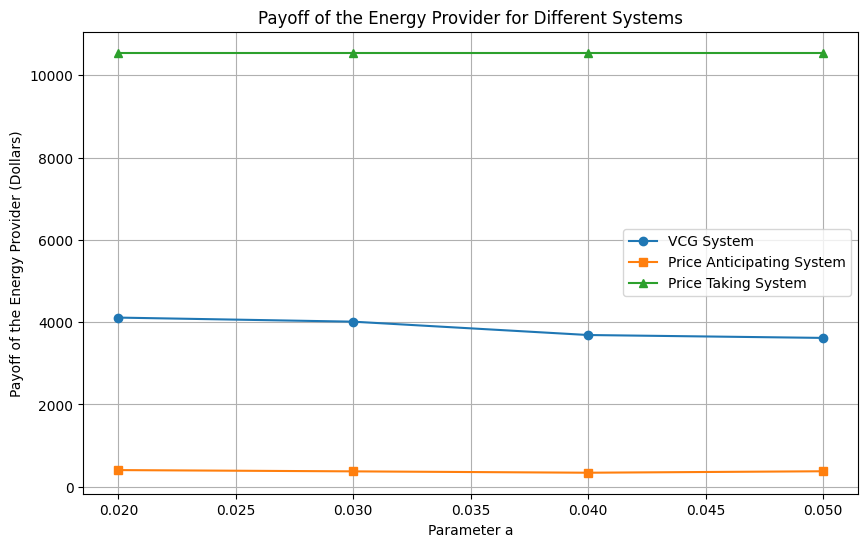

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Constants
num_users = 50
omega_set = np.array([15, 25, 30, 40])
E_n = np.random.uniform(10, 15, num_users)
m_k = np.array([0.1, 0.5, 1.0])
a_values = [0.02, 0.03, 0.04, 0.05]
alpha = 0.5
K = len(m_k)
lambda_k = np.array([1.0, 1.5, 2.0])  # Example fixed prices for time slots

# Utility function
def utility_function(x, omega):
    if x < omega / alpha:
        return omega * x - (alpha / 2) * x**2
    else:
        return omega**2 / (2 * alpha)

# Cost function
def cost_function(L, a):
    return a * L**2

# Price function
def price_function(L, price_multiplier):
    return base_price + price_multiplier * L  # Adjusted price function with a multiplier

# VCG Payment Calculation
def vcg_payment(x, n, omega, a):
    N = list(range(num_users))
    N_minus_n = N.copy()
    N_minus_n.remove(n)

    x_n = x[n * K:(n + 1) * K]
    x_minus_n = np.delete(x, np.s_[n * K:(n + 1) * K])

    total_utility_minus_n = np.sum([utility_function(np.sum(x_minus_n[m * (K - 1):(m + 1) * (K - 1)]), omega[m]) for m in N_minus_n])
    total_cost_minus_n = np.sum([cost_function(np.sum(x_minus_n[k::K]), a) for k in range(K)])
    total_utility = np.sum([utility_function(np.sum(x[m * K:(m + 1) * K]), omega[m]) for m in N])
    total_cost = np.sum([cost_function(np.sum(x[k::K]), a) for k in range(K)])

    return total_utility_minus_n - total_cost_minus_n - (total_utility - total_cost)

# Objective function for VCG
def objective_vcg(x, omega, a):
    total_utility = 0
    total_cost = 0
    total_vcg_payment = 0
    for n in range(num_users):
        total_utility += utility_function(np.sum(x[n * K:(n + 1) * K]), omega[n])
        total_vcg_payment += vcg_payment(x, n, omega, a)
    for k in range(K):
        total_cost += cost_function(np.sum(x[k::K]), a)
    return -(total_utility - total_cost + total_vcg_payment)

# Objective function for Price-Taking Users
def objective_price_taking(x, omega):
    total_payment = 0
    for n in range(num_users):
        total_payment += np.sum([lambda_k[k % K] * x[n * K + k] for k in range(K)])
    return -total_payment

# Objective function for Price-Anticipating Users
def objective_price_anticipating(x, omega, price_multiplier):
    total_utility = 0
    total_payment = 0
    for n in range(num_users):
        total_utility += utility_function(np.sum(x[n * K:(n + 1) * K]), omega[n])
    for k in range(K):
        total_payment += np.sum([x[n * K + k] * price_function(np.sum(x[k::K]), price_multiplier) for n in range(num_users)])
    return -(total_utility - total_payment)

# Constraints
def constraint_min_energy(x):
    return np.array([np.sum(x[n * K:(n + 1) * K]) - E_n[n] for n in range(num_users)])

def constraint_power_limits(x):
    constraints = []
    for n in range(num_users):
        for k in range(K):
            constraints.append(x[n * K + k] - m_k[k])  # x_k^n >= m_k
            constraints.append(M_k[k] - x[n * K + k])  # x_k^n <= M_k
    return np.array(constraints)

# Bounds
M_k = np.array([2.0, 3.0, 4.0])  # Example maximum values for the power limits
bounds = [(0, M_k[k % K]) for k in range(num_users * K)]

# Optimization
vcg_payoffs = []
price_anticipating_payoffs = []
price_taking_payoffs = []

omega = np.random.choice(omega_set, num_users)

for a in a_values:
    x0 = np.random.uniform(0.1, 1, num_users * K)

    # VCG System
    cons = [{'type': 'ineq', 'fun': constraint_min_energy},
            {'type': 'ineq', 'fun': constraint_power_limits}]
    solution_vcg = minimize(objective_vcg, x0, args=(omega, a), method='SLSQP', bounds=bounds, constraints=cons)
    x_opt_vcg = solution_vcg.x
    total_utility_vcg = np.sum([utility_function(np.sum(x_opt_vcg[n * K:(n + 1) * K]), omega[n]) for n in range(num_users)])
    total_cost_vcg = np.sum([cost_function(np.sum(x_opt_vcg[k::K]), a) for k in range(K)])
    vcg_payoff = total_utility_vcg - total_cost_vcg

    # Adjust price function to ensure non-negative payoffs
    price_multiplier = 0.2
    base_price = 0.1
    while True:
        # Price Anticipating System
        solution_price_anticipating = minimize(objective_price_anticipating, x0, args=(omega, price_multiplier), method='SLSQP', constraints=cons)
        x_opt_price_anticipating = solution_price_anticipating.x
        total_utility_price_anticipating = np.sum([utility_function(np.sum(x_opt_price_anticipating[n * K:(n + 1) * K]), omega[n]) for n in range(num_users)])
        total_payment_price_anticipating = np.sum([x_opt_price_anticipating[n * K + k] * price_function(np.sum(x_opt_price_anticipating[k::K]), price_multiplier) for n in range(num_users) for k in range(K)])
        price_anticipating_payoff = total_utility_price_anticipating - total_payment_price_anticipating

        # Price Taking System
        solution_price_taking = minimize(objective_price_taking, x0, args=(omega,), method='SLSQP', bounds=bounds, constraints=cons)
        x_opt_price_taking = solution_price_taking.x
        total_utility_price_taking = np.sum([utility_function(np.sum(x_opt_price_taking[n * K:(n + 1) * K]), omega[n]) for n in range(num_users)])
        total_payment_price_taking = np.sum([lambda_k[k % K] * x_opt_price_taking[n * K + k] for n in range(num_users) for k in range(K)])
        price_taking_payoff = total_utility_price_taking - total_payment_price_taking

        if price_anticipating_payoff >= 0 and price_taking_payoff >= 0:
            break
        price_multiplier += 0.1  # Increment price multiplier to increase payoffs
        base_price += 0.1
    # Append payoffs
    vcg_payoffs.append(vcg_payoff)
    price_anticipating_payoffs.append(price_anticipating_payoff)
    price_taking_payoffs.append(price_taking_payoff)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(a_values, vcg_payoffs, label='VCG System', marker='o')
plt.plot(a_values, price_anticipating_payoffs, label='Price Anticipating System', marker='s')
plt.plot(a_values, price_taking_payoffs, label='Price Taking System', marker='^')
plt.xlabel('Parameter a')
plt.ylabel('Payoff of the Energy Provider (Dollars)')
plt.title('Payoff of the Energy Provider for Different Systems')
plt.legend()
plt.grid(True)
plt.show()


# exchaneg messages

In [ ]:
import numpy as np

# Initialize parameters
user_counts = [10, 20, 30, 40, 50]
a_values = [0.02, 0.3, 0.5]  # Cost function parameters for off-peak, mid-peak, and on-peak hours
K = 24  # Number of time slots
price_anticipating_messages = []
vcg_messages = []

# Utility function
def U(x, omega, alpha=0.5):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Myopic best-response algorithm to compute Nash equilibrium
def myopic_best_response(N, K, omega, a):
    # Initialize random power consumption for users
    x = np.random.uniform(0.1, 1, (N, K))
    messages = 0

    # Iterate until convergence
    for _ in range(1000):  # Max number of iterations
        converged = True
        for n in range(N):
            best_response = x[n].copy()
            best_utility = U(np.sum(best_response), omega[n])
            for k in range(K):
                x_temp = x[n].copy()
                x_temp[k] = np.random.uniform(0.1, 1)  # Randomly change power consumption
                utility = U(np.sum(x_temp), omega[n])
                if utility > best_utility:
                    best_response = x_temp
                    best_utility = utility
                    converged = False
                    messages += 1
            x[n] = best_response
        if converged:
            break
    return messages

for N in user_counts:
    # Generate omega values for users
    omega_values = np.random.choice([15, 25, 30, 40], N)
    omega = np.random.choice(omega_values, N)
    E_n = np.random.uniform(10, 15, size=N)  # Energy requirements for each user
    m_k = np.zeros(K)

    # Define peak hour categories and minimum power requirements
    off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24]
    on_peak_hours = [15, 16, 17, 18, 19]

    # Set minimum power requirements for each time slot
    for k in range(K):
        if k in off_peak_hours:
            m_k[k] = 0.1
        elif k in mid_peak_hours:
            m_k[k] = 0.5
        else:
            m_k[k] = 1.0

    # Initialize cost coefficients
    a = np.zeros(K)
    for k in range(K):
        if k in off_peak_hours:
            a[k] = 0.02
        elif k in mid_peak_hours:
            a[k] = 0.3
        else:
            a[k] = 0.5

    # VCG system
    vcg_messages.append(N * 2)  # Each user sends its omega and power consumption to the energy provider

    # Price anticipating system
    price_anticipating_messages.append(myopic_best_response(N, K, omega, a))

# Print the results in a table format
print(f"{'Number of Users N':<20} {'Price Anticipating System':<30} {'VCG System':<20}")
for i, N in enumerate(user_counts):
    print(f"{N:<20} {price_anticipating_messages[i]:<30} {vcg_messages[i]:<20}")

# Display the results in a table format
import pandas as pd

data = {
    'Number of Users N': user_counts,
    'Price Anticipating System': price_anticipating_messages,
    'VCG System': vcg_messages
}

df = pd.DataFrame(data)
print(df)


Number of Users N    Price Anticipating System      VCG System          
10                   1066                           20                  
20                   2400                           40                  
30                   4116                           60                  
40                   5676                           80                  
50                   7122                           100                 
   Number of Users N  Price Anticipating System  VCG System
0                 10                       1066          20
1                 20                       2400          40
2                 30                       4116          60
3                 40                       5676          80
4                 50                       7122         100


# Effect of parameter w

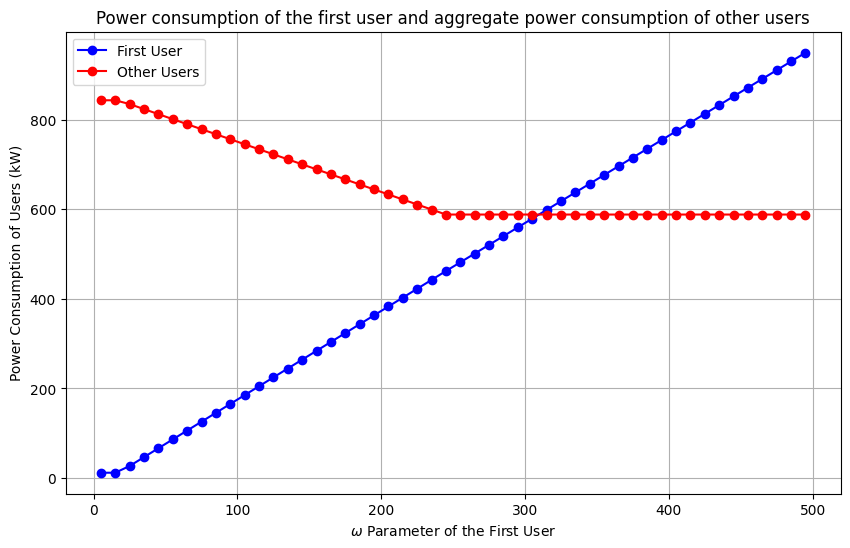

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 50  # Number of users
K = 3  # Number of time slots
omega_values = [20] * (N - 1)  # Omega values for all users except the first user
E_n = np.full(N, 12)  # Energy requirements for each user
m_k = np.zeros(K)  # Minimum power requirements for each time slot
a = 0.02  # Cost function parameter

# Define utility function
def U(x, omega, alpha=0.5):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Define cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Define social objective function to maximize
def social_objective(x, omega, a):
    x = x.reshape(N, K)
    total_utility = 0
    total_cost = 0

    # Calculate the social objective
    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    for k in range(K):
        total_cost += C(np.sum(x[:, k]), a)

    social_welfare = total_utility - total_cost
    return -social_welfare

# Define constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(0.1, 0.5, N * K)

# Constraints dictionary
constraints = [{'type': 'ineq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Arrays to store results
omega_first_user_values = np.arange(5, 505, 10)
power_consumption_first_user = []
aggregate_power_consumption_others = []

for omega_first_user in omega_first_user_values:
    omega = [omega_first_user] + omega_values

    # Solve the optimization problem
    solution_vcg = minimize(social_objective, x0, args=(omega, a), method='SLSQP', constraints=constraints)
    x_opt_vcg = solution_vcg.x.reshape(N, K)

    # Calculate power consumption for the first user and other users
    power_consumption_first_user.append(np.sum(x_opt_vcg[0]))
    aggregate_power_consumption_others.append(np.sum(x_opt_vcg[1:]))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(omega_first_user_values, power_consumption_first_user, label='First User', marker='o', color='blue')
plt.plot(omega_first_user_values, aggregate_power_consumption_others, label='Other Users', marker='o', color='red')
plt.xlabel(r'$\omega$ Parameter of the First User')
plt.ylabel('Power Consumption of Users (kW)')
plt.title('Power consumption of the first user and aggregate power consumption of other users')
plt.legend()
plt.grid(True)
plt.show()


#Truthfulness

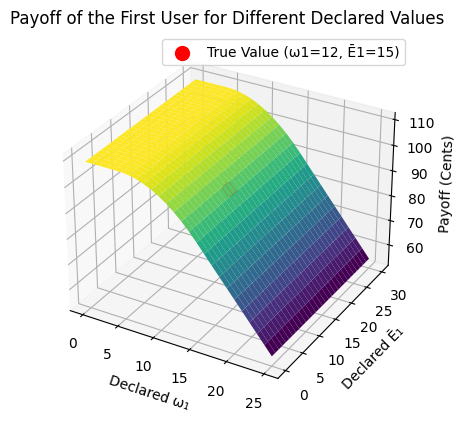

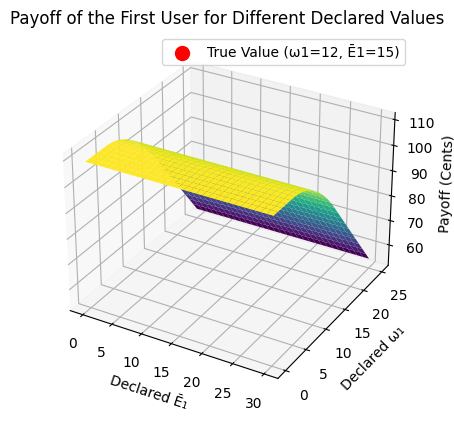

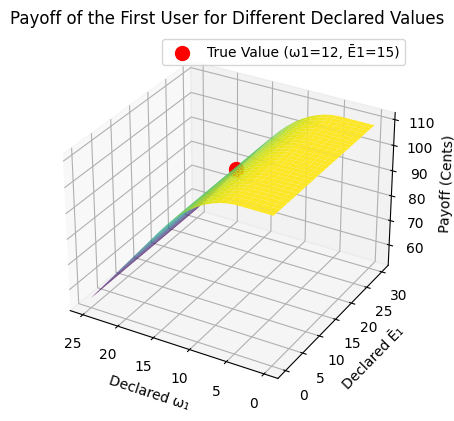

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Initialize parameters
N = 10  # Number of users
K = 3   # Number of time slots
omega_true = np.array([12, 6, 8, 8, 10, 10, 12, 12, 16, 20])
E_n = np.full(N, 15)  # Energy requirements for each user
m_k = np.zeros(K)     # Minimum power requirements for each time slot
a = 0.02              # Cost function parameter
alpha = 0.5           # Parameter for utility function

# Utility function
def U(x, omega, alpha=0.3):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Social objective function to maximize
def social_objective(x, omega, a):
    x = x.reshape(len(omega), K)
    total_utility = np.sum([U(np.sum(x[n]), omega[n]) for n in range(len(omega))])
    total_cost = np.sum([C(np.sum(x[:, k]), a) for k in range(K)])
    social_welfare = total_utility - total_cost
    return -social_welfare

# Constraints
def constraint_min_energy(x, E_n):
    x = x.reshape(len(E_n), K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x, m_k):
    x = x.reshape(len(x) // K, K)  # Dynamically reshape based on input length
    return np.min(x, axis=0) - m_k

# Initial guess
x0 = np.random.uniform(0, 5, N * K)

# Constraints dictionary
constraints = [{'type': 'eq', 'fun': lambda x: constraint_min_energy(x, E_n)},
               {'type': 'ineq', 'fun': lambda x: constraint_min_power(x, m_k)}]

# Declare the range for declared values of ω1 and E1
declared_omega1_range = np.arange(0, 26, 1)
declared_E1_range = np.arange(0, 31, 1)

# Initialize the payoff matrix
payoff_matrix = np.zeros((len(declared_omega1_range), len(declared_E1_range)))

# True values for the first user
omega1_true = 12
E1_true = 15

# Run the optimization for different declared values
for i, omega1_declared in enumerate(declared_omega1_range):
    for j, E1_declared in enumerate(declared_E1_range):
        omega_declared = omega_true.copy()
        E_declared = E_n.copy()
        omega_declared[0] = omega1_declared
        E_declared[0] = E1_declared

        # Solve the optimization problem
        solution = minimize(social_objective, x0, args=(omega_declared, a), method='SLSQP', constraints=constraints)
        x_opt = solution.x.reshape(N, K)

        # Calculate the VCG payments
        total_cost = np.sum([C(np.sum(x_opt[:, k]), a) for k in range(K)])
        user_payments = []
        for n in range(N):
            omega_without_n = np.delete(omega_declared, n)
            E_without_n = np.delete(E_declared, n)
            x0_without_n = np.random.uniform(0, 5, (N - 1) * K)
            constraints_without_n = [{'type': 'eq', 'fun': lambda x: constraint_min_energy(x, E_without_n)},
                                     {'type': 'ineq', 'fun': lambda x: constraint_min_power(x, m_k)}]
            solution_without_n = minimize(social_objective, x0_without_n, args=(omega_without_n, a), method='SLSQP', constraints=constraints_without_n)
            x_opt_without_n = solution_without_n.x.reshape(N-1, K)
            social_welfare_without_n = np.sum([U(np.sum(x_opt_without_n[i]), omega_without_n[i]) for i in range(N-1)]) - np.sum([C(np.sum(x_opt_without_n[:, k]), a) for k in range(K)])
            social_welfare_with_n = np.sum([U(np.sum(x_opt[:, k]), omega_declared[k]) for k in range(K)]) - total_cost
            payment = social_welfare_without_n - (social_welfare_with_n - U(np.sum(x_opt[n]), omega_declared[n]))
            user_payments.append(max(0, payment))  # Ensure non-negative payments

        # Calculate the payoff for the first user
        payoff_matrix[i, j] = 0.1*user_payments[0]

# Plot the results
X, Y = np.meshgrid(declared_omega1_range, declared_E1_range)
Z = payoff_matrix.T  # Transpose to match the correct orientation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Plot the true value point
true_value = np.array([omega1_true, E1_true, 90.9])  # Replace 90.9 with the correct z-value if different
ax.scatter(true_value[0], true_value[1], true_value[2], color='r', s=100, label='True Value (ω1=12, Ē1=15)')
ax.legend()

ax.set_xlabel('Declared ω₁')
ax.set_ylabel('Declared Ē₁')
ax.set_zlabel('Payoff (Cents)')
ax.set_title('Payoff of the First User for Different Declared Values')

plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Y, X, Z, cmap='viridis')

# Plot the true value point
true_value = np.array([omega1_true, E1_true, 90.9])  # Replace 90.9 with the correct z-value if different
ax.scatter(true_value[0], true_value[1], true_value[2], color='r', s=100, label='True Value (ω1=12, Ē1=15)')
ax.legend()

ax.set_xlabel('Declared Ē₁')
ax.set_ylabel('Declared ω₁')
ax.set_zlabel('Payoff (Cents)')
ax.set_title('Payoff of the First User for Different Declared Values')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Plot the true value point
true_value = np.array([omega1_true, E1_true, payoff_matrix[omega1_true, E1_true]])  # Adjust z-value based on the payoff matrix
ax.scatter(true_value[0], true_value[1], true_value[2], color='r', s=100, label='True Value (ω1=12, Ē1=15)')
ax.legend()

ax.set_xlabel('Declared ω₁')
ax.set_ylabel('Declared Ē₁')
ax.set_zlabel('Payoff (Cents)')
ax.set_title('Payoff of the First User for Different Declared Values')
ax.invert_xaxis()  # Invert the x-axis

plt.show()

#Q-Learning

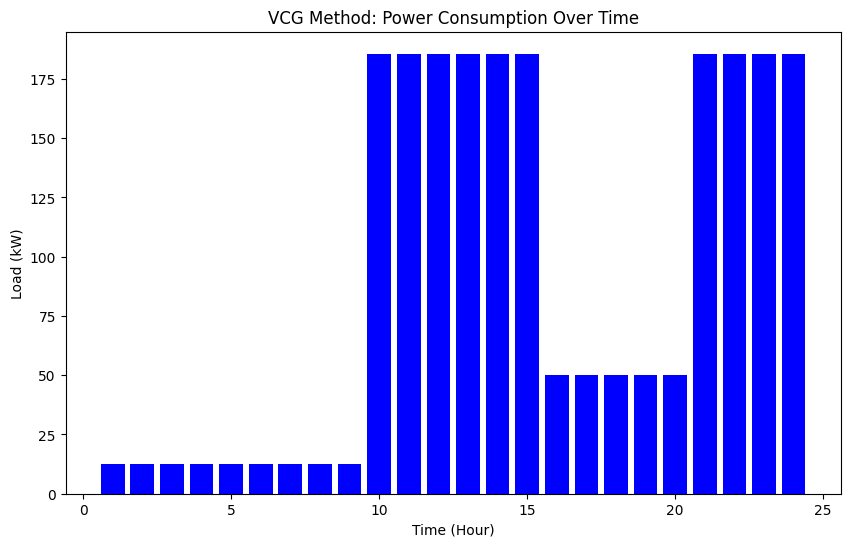

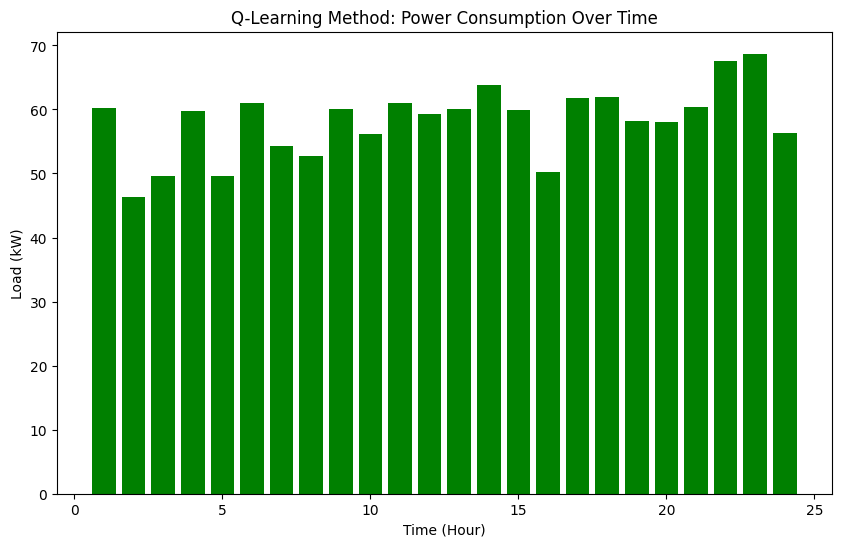

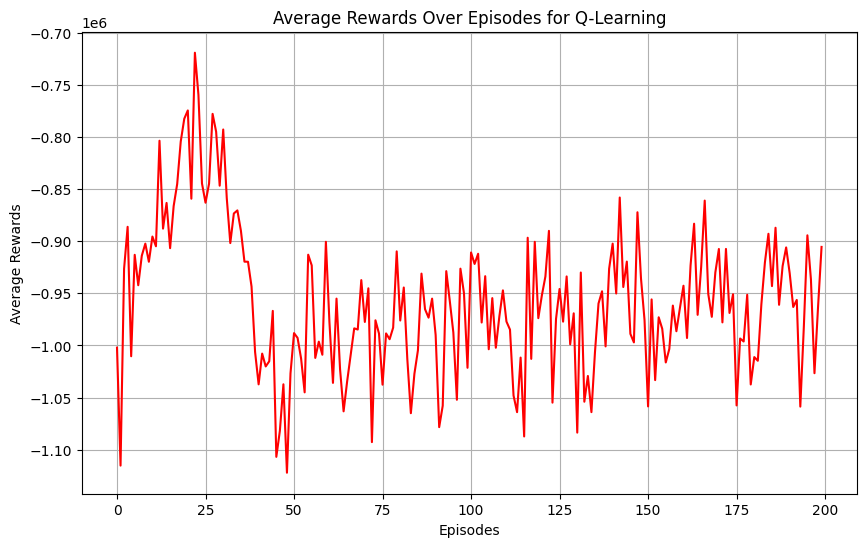

PAR of VCG System: 2.009034205168006
PAR of Q-Learning System: 1.1801589005797724


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize

# Initialize parameters
N = 50  # Number of users
K = 24  # Number of time slots
omega_values = [15, 25, 30, 40]
omega = np.random.choice(omega_values, N)
E_n = np.random.uniform(10, 15, size=N)  # Energy requirements for each user
m_k = np.zeros(K)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23]
on_peak_hours = [15, 16, 17, 18, 19]

# Set minimum power requirements for each time slot
for k in range(K):
    if k in off_peak_hours:
        m_k[k] = 0.1
    elif k in mid_peak_hours:
        m_k[k] = 0.5
    else:
        m_k[k] = 1.0

# Cost function parameters
a_off_peak = 0.3
a_mid_peak = 0.2
a_on_peak = 0.5
a = np.array([a_off_peak if k in off_peak_hours else a_mid_peak if k in mid_peak_hours else a_on_peak for k in range(K)])

# Utility function
def U(x, omega, alpha=0.5):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Social objective function to maximize
def social_objective(x, omega, a):
    x = x.reshape(N, K)
    total_utility = 0
    total_cost = 0

    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    for k in range(K):
        total_cost += C(np.sum(x[:, k]), a[k])

    social_welfare = total_utility - total_cost
    return -social_welfare

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(0.1, 0.5, N * K)

# Constraints dictionary
constraints = [{'type': 'ineq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Q-Learning parameters
learning_rate = 0.1
discount_factor = 0.9
exploration_rate = 1.0
exploration_decay = 0.995
episodes = 200

# Initialize Q-values
Q = np.zeros((N, K, K))
average_rewards = []

def get_reward(state, omega, a):
    state = state.reshape(N, K)
    total_utility = 0
    total_cost = 0

    for n in range(N):
        total_utility += U(np.sum(state[n]), omega[n])

    for k in range(K):
        total_cost += C(np.sum(state[:, k]), a[k])

    social_welfare = total_utility - total_cost
    return social_welfare

# VCG System
solution_vcg = minimize(social_objective, np.random.uniform(0.1, 0.5, N * K), args=(omega, a), method='SLSQP', constraints=constraints)
x_opt_vcg = solution_vcg.x.reshape(N, K)
total_cost_vcg = np.sum([C(np.sum(x_opt_vcg[:, k]), a[k]) for k in range(K)])
total_revenue_vcg = np.sum([np.sum(x_opt_vcg[:, k]) * a[k] for k in range(K)])
payoff_vcg = total_revenue_vcg - total_cost_vcg

# Calculate PAR for VCG System
par_vcg = np.max(np.sum(x_opt_vcg, axis=0)) / np.mean(np.sum(x_opt_vcg, axis=0))

# Q-Learning for each episode
for episode in range(episodes):
    state = np.random.uniform(0.1, 0.5, (N, K))
    total_reward = 0

    for t in range(K):
        actions = []

        for n in range(N):
            if random.uniform(0, 1) < exploration_rate:
                action = np.random.randint(0, K)
            else:
                action = np.argmax(Q[n, :, t])

            actions.append(action)

        new_state = np.copy(state)
        for n in range(N):
            new_state[n, t] = actions[n]

        reward = get_reward(new_state, omega, a)

        for n in range(N):
            best_next_action = np.argmax(Q[n, :, t])
            td_target = reward + discount_factor * Q[n, best_next_action, t]
            td_error = td_target - Q[n, actions[n], t]
            Q[n, actions[n], t] += learning_rate * td_error

        state = new_state
        total_reward += reward

    average_rewards.append(total_reward / K)
    exploration_rate *= exploration_decay

# Calculate total cost and revenue for Q-learning
total_cost_q_learning = np.sum([C(np.sum(state[:, k]), a[k]) for k in range(K)])
total_revenue_q_learning = np.sum([np.sum(state[:, k]) * a[k] for k in range(K)])
payoff_q_learning = total_revenue_q_learning - total_cost_q_learning

# Calculate PAR for Q-Learning System
par_q_learning = np.max(np.sum(state, axis=0)) / np.mean(np.sum(state, axis=0))

# Plotting the results for VCG System
plt.figure(figsize=(10, 6))
plt.bar(range(1, K+1), np.sum(x_opt_vcg, axis=0), color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('VCG Method: Power Consumption Over Time')
plt.show()

# Plotting the results for Q-Learning System
plt.figure(figsize=(10, 6))
plt.bar(range(1, K+1),0.1*np.sum(state, axis=0), color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('Q-Learning Method: Power Consumption Over Time')
plt.show()

# Plotting the average rewards
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), average_rewards, color='red')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Rewards Over Episodes for Q-Learning')
plt.grid(True)
plt.show()


print(f'PAR of VCG System: {par_vcg}')

print(f'PAR of Q-Learning System: {par_q_learning}')


#Dyna Q+ learning single agent for PAR compared to VCG

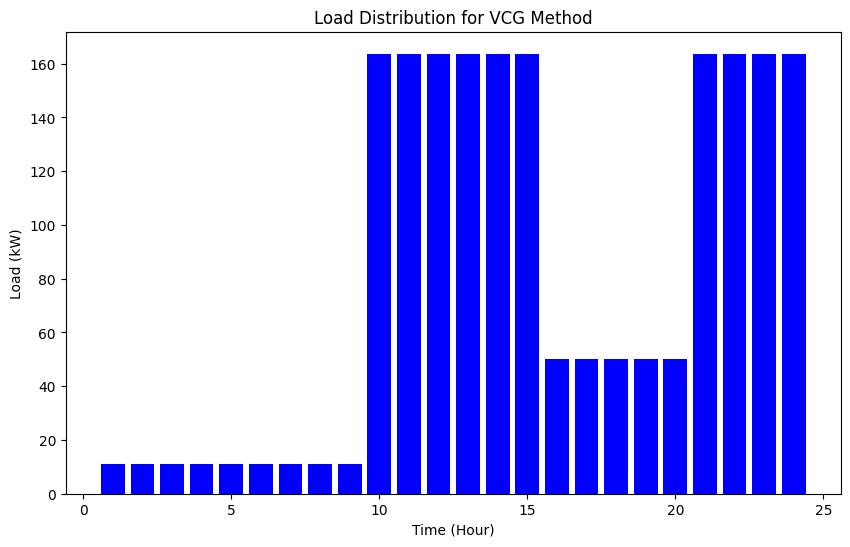

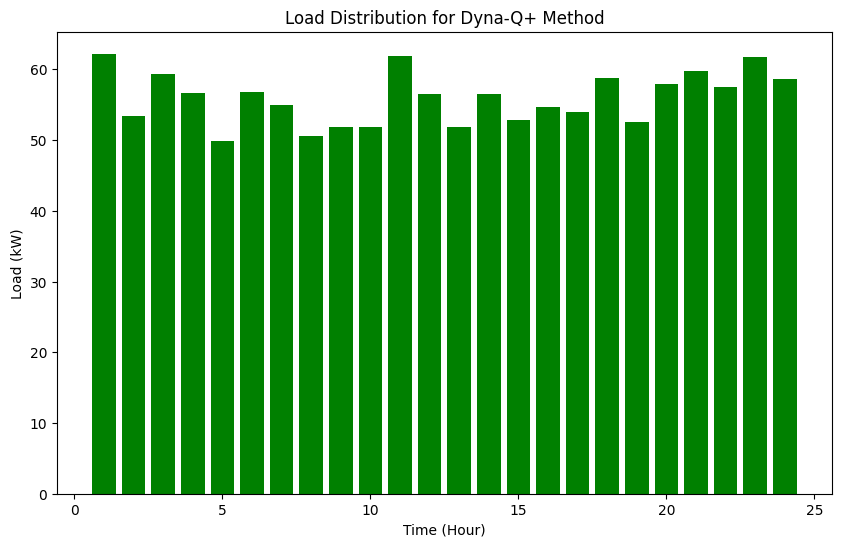

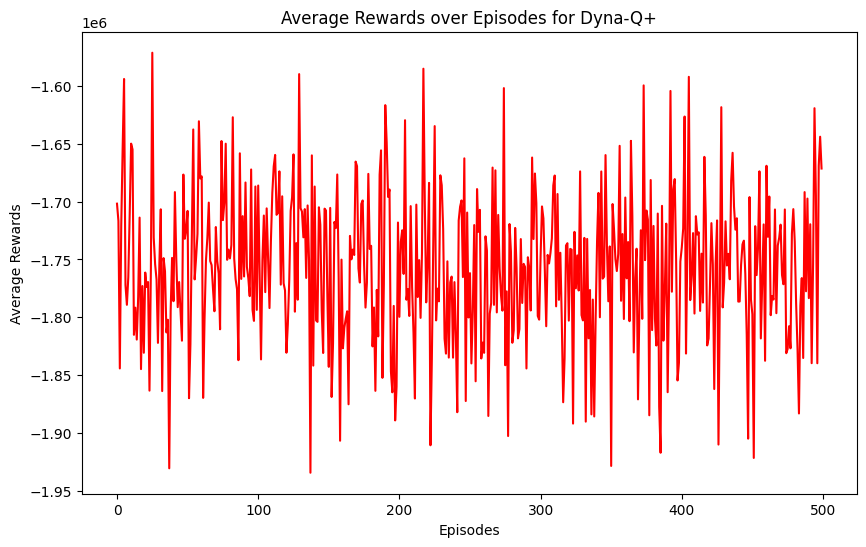

PAR for VCG System: 1.9790480002589088
PAR for Dyna-Q+ System: 1.1119553072625699


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from collections import defaultdict

# Initialize parameters
N = 50  # Number of users
K = 24  # Number of time slots
omega_values = [15, 25, 30, 40]
omega = np.random.choice(omega_values, N)
E_n = np.random.uniform(10, 15, size=N)  # Energy requirements for each user
m_k = np.zeros(K)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23]
on_peak_hours = [15, 16, 17, 18, 19]

# Set minimum power requirements for each time slot
for k in range(K):
    if k in off_peak_hours:
        m_k[k] = 0.1
    elif k in mid_peak_hours:
        m_k[k] = 0.5
    else:
        m_k[k] = 1.0

# Define cost function coefficients a
a = np.zeros(K)
for k in range(K):
    if k in off_peak_hours:
        a[k] = 0.3
    elif k in mid_peak_hours:
        a[k] = 0.2
    else:
        a[k] = 0.5

# Utility function
def U(x, omega, alpha=0.5):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a):
    return a * L ** 2

# Social objective function to maximize
def social_objective(x, omega, a):
    x = x.reshape(N, K)
    total_utility = 0
    total_cost = 0

    for n in range(N):
        total_utility += U(np.sum(x[n]), omega[n])

    for k in range(K):
        total_cost += C(np.sum(x[:, k]), a[k])

    social_welfare = total_utility - total_cost
    return -social_welfare

# Constraints
def constraint_min_energy(x):
    x = x.reshape(N, K)
    return np.sum(x, axis=1) - E_n

def constraint_min_power(x):
    x = x.reshape(N, K)
    min_power_constraints = np.zeros(N * K)
    for k in range(K):
        min_power_constraints[k::K] = x[:, k] - m_k[k]
    return min_power_constraints

# Initial guess
x0 = np.random.uniform(0.1, 0.5, N * K)

# Constraints dictionary
constraints = [{'type': 'ineq', 'fun': constraint_min_energy},
               {'type': 'ineq', 'fun': constraint_min_power}]

# Dyna-Q+ parameters
learning_rate = 0.01
discount_factor = 0.9
exploration_rate = 1.0
exploration_decay = 0.995
episodes = 500
planning_steps = 10
kappa = 0.01

# Initialize Q-values and model
Q = np.zeros((N, K, K))
model = defaultdict(lambda: (np.zeros((N, K)), 0))
time_since_visited = defaultdict(lambda: 0)

def get_reward(state, omega, a):
    state = state.reshape(N, K)
    total_utility = 0
    total_cost = 0

    for n in range(N):
        total_utility += U(np.sum(state[n]), omega[n])

    for k in range(K):
        total_cost += C(np.sum(state[:, k]), a[k])

    social_welfare = total_utility - total_cost
    return social_welfare

# VCG System
solution_vcg = minimize(social_objective, np.random.uniform(0.1, 0.5, N * K), args=(omega, a), method='SLSQP', constraints=constraints)
x_opt_vcg = solution_vcg.x.reshape(N, K)
total_cost_vcg = np.sum([C(np.sum(x_opt_vcg[:, k]), a[k]) for k in range(K)])
total_revenue_vcg = np.sum([np.sum(x_opt_vcg[:, k]) * a[k] for k in range(K)])
payoff_vcg = total_revenue_vcg - total_cost_vcg

# Calculate PAR for VCG System
par_vcg = np.max(np.sum(x_opt_vcg, axis=0)) / np.mean(np.sum(x_opt_vcg, axis=0))

# Dyna-Q+ for each episode
rewards = []

for episode in range(episodes):
    state = np.random.randint(0, K, size=(N, K))
    total_reward = 0

    for t in range(K):
        actions = []

        for n in range(N):
            if random.uniform(0, 1) < exploration_rate:
                action = np.random.randint(0, K)
            else:
                action = np.argmax(Q[n, state[n, t]])

            actions.append(action)

        new_state = np.copy(state)
        for n in range(N):
            new_state[n, t] = actions[n]

        reward = get_reward(new_state, omega, a)

        # Update model
        model[(tuple(state.flatten()), tuple(actions))] = (new_state, reward)
        time_since_visited[tuple(state.flatten())] += 1

        # Update Q-values
        for n in range(N):
            best_next_action = np.argmax(Q[n, new_state[n, t]])
            td_target = reward + discount_factor * Q[n, new_state[n, t], best_next_action]
            td_error = td_target - Q[n, state[n, t], actions[n]]
            Q[n, state[n, t], actions[n]] += learning_rate * td_error

        # Planning with simulated experience
        for _ in range(planning_steps):
            sim_state, sim_actions = random.choice(list(model.keys()))
            sim_next_state, sim_reward = model[(sim_state, sim_actions)]
            sim_state = np.array(sim_state).reshape(N, K)
            sim_actions = np.array(sim_actions)

            for n in range(N):
                best_next_action = np.argmax(Q[n, sim_next_state[n, t]])
                td_target = sim_reward + discount_factor * Q[n, sim_next_state[n, t], best_next_action] + kappa * np.sqrt(time_since_visited[tuple(sim_state.flatten())])
                td_error = td_target - Q[n, sim_state[n, t], sim_actions[n]]
                Q[n, sim_state[n, t], sim_actions[n]] += learning_rate * td_error

        state = new_state
        total_reward += reward

    rewards.append(total_reward / K)
    exploration_rate *= exploration_decay

# Calculate total cost and revenue for Dyna-Q+
total_cost_dyna_q_plus = np.sum([C(np.sum(state[:, k]), a[k]) for k in range(K)])
total_revenue_dyna_q_plus = np.sum([np.sum(state[:, k]) * a[k] for k in range(K)])
payoff_dyna_q_plus = total_revenue_dyna_q_plus - total_cost_dyna_q_plus

# Calculate PAR for Dyna-Q+ System
par_dyna_q_plus = np.max(np.sum(state, axis=0)) / np.mean(np.sum(state, axis=0))

# Plotting the load for VCG System
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, K + 1), np.sum(x_opt_vcg, axis=0), color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('Load Distribution for VCG Method')
plt.show()

# Plotting the load for Dyna-Q+ System
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, K + 1), 0.1*np.sum(state, axis=0), color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')
plt.title('Load Distribution for Dyna-Q+ Method')
plt.show()

# Plotting the average rewards for Dyna-Q+
plt.figure(figsize=(10, 6))
plt.plot(rewards, color='red')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Rewards over Episodes for Dyna-Q+')
plt.show()

# Reporting the PAR values
print(f'PAR for VCG System: {par_vcg}')
print(f'PAR for Dyna-Q+ System: {par_dyna_q_plus}')



#DQN for PAR

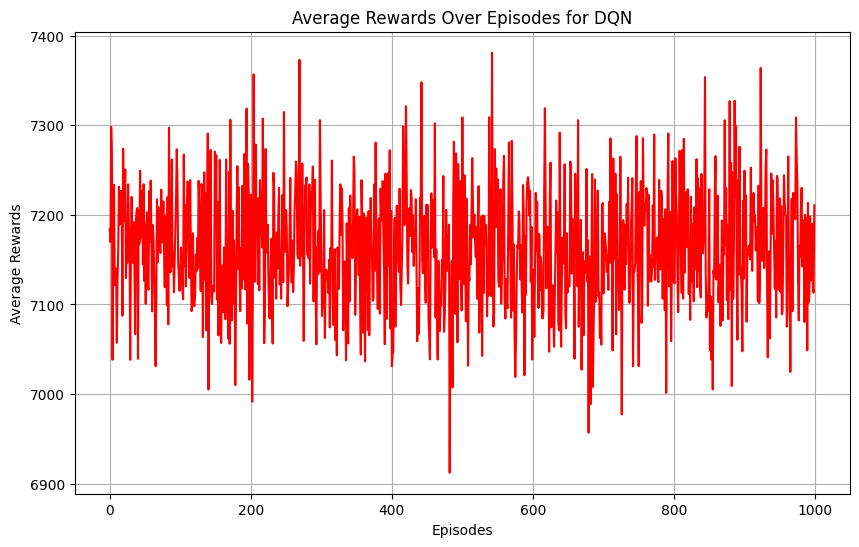

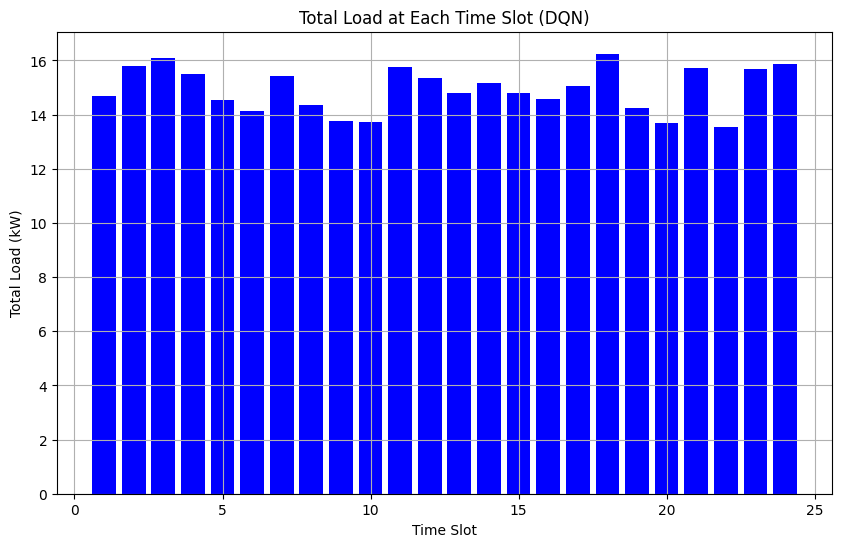

PAR of DQN System: 1.0874870486001713
Payoff of Q-Learning System: 7162225.090734169


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim

# Neural Network for Q-Learning
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize parameters
N = 50  # Number of users
K = 24  # Number of time slots
omega_values = [15, 25, 30, 40]
omega = np.random.choice(omega_values, N)
E_n = np.random.uniform(10, 15, size=N)  # Energy requirements for each user
m_k = np.zeros(K)

# Define peak hour categories and minimum power requirements
off_peak_hours = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mid_peak_hours = [9, 10, 11, 12, 13, 14, 20, 21, 22, 23]
on_peak_hours = [15, 16, 17, 18, 19]

# Set minimum power requirements for each time slot
for k in range(K):
    if k in off_peak_hours:
        m_k[k] = 0.1
    elif k in mid_peak_hours:
        m_k[k] = 0.5
    else:
        m_k[k] = 1.0

# Cost function parameters
a_off_peak = 0.02
a_mid_peak = 0.3
a_on_peak = 0.5
a = np.array([a_off_peak if k in off_peak_hours else a_mid_peak if k in mid_peak_hours else a_on_peak for k in range(K)])

# Utility function
def U(x, omega, alpha=0.5):
    return np.where(x < omega / alpha, omega * x - alpha / 2 * x ** 2, omega ** 2 / (2 * alpha))

# Cost function
def C(L, a, b=0, c=0):
    return a * L ** 2 + b * L + c

# Q-Learning parameters
learning_rate = 0.001
discount_factor = 0.9
exploration_rate = 1.0
exploration_decay = 0.9
episodes = 1000
state_size = N * K
action_size = K

# Initialize Q-network and optimizer
q_network = QNetwork(state_size, action_size)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

average_rewards = []

def get_reward(state, omega, a):
    state = state.reshape(N, K)
    total_utility = 0
    total_cost = 0

    for n in range(N):
        total_utility += U(np.sum(state[n]), omega[n])

    for k in range(K):
        total_cost += C(np.sum(state[:, k]), a[k])

    social_welfare = total_utility - total_cost
    return social_welfare

# Q-Learning for each episode
for episode in range(episodes):
    state = np.random.uniform(0.1, 0.5, (N, K)).flatten()
    total_reward = 0

    for t in range(K):
        state_tensor = torch.FloatTensor(state)
        q_values = q_network(state_tensor)

        if random.uniform(0, 1) < exploration_rate:
            action = np.random.randint(0, K)
        else:
            action = torch.argmax(q_values).item()

        new_state = np.copy(state)
        new_state[action] = random.uniform(0.1, 1.0)

        reward = get_reward(new_state.reshape(N, K), omega, a)
        new_state_tensor = torch.FloatTensor(new_state)
        target = reward + discount_factor * torch.max(q_network(new_state_tensor))
        target_f = q_values.clone()
        target_f[action] = target

        optimizer.zero_grad()
        loss = criterion(q_values, target_f)
        loss.backward()
        optimizer.step()

        state = new_state
        total_reward += reward

    average_rewards.append(total_reward / K)
    exploration_rate *= exploration_decay

# Final state after training
final_state = state.reshape(N, K)

# Plotting the average rewards
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), average_rewards, color='red')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Rewards Over Episodes for DQN')
plt.grid(True)
plt.show()

# Calculate and plot total loads
total_loads = np.sum(final_state, axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(1, K+1), total_loads, color='blue')
plt.xlabel('Time Slot')
plt.ylabel('Total Load (kW)')
plt.title('Total Load at Each Time Slot (DQN)')
plt.grid(True)
plt.show()

# Calculate PAR
par_dqn = np.max(total_loads) / np.mean(total_loads)
print(f'PAR of DQN System: {par_dqn}')

print(f'Payoff of Q-Learning System: {np.sum(average_rewards)}')


# DQN for Pay off comapred to VCG with a changing

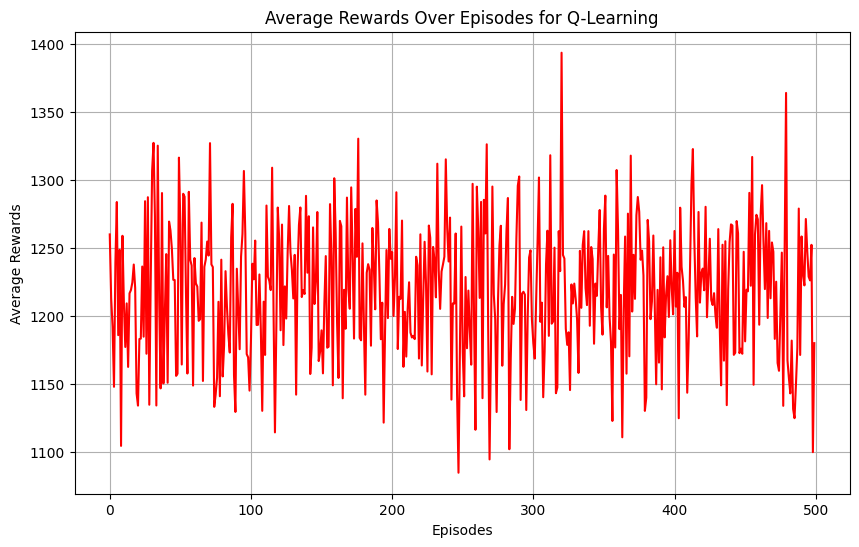

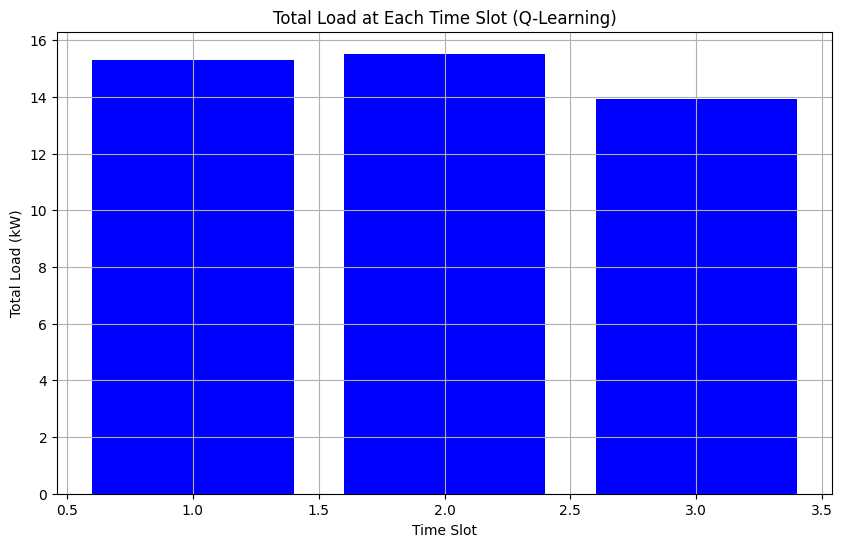

PAR of Q-Learning System: 1.040792742957734
Final Payoff of Q-Learning System: 1144.486077698773


TypeError: can't multiply sequence by non-int of type 'float'

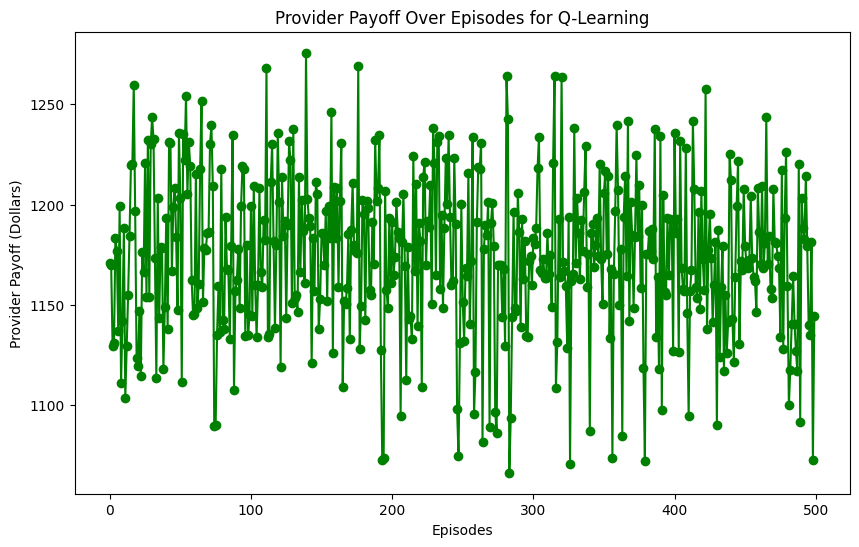

<Figure size 1000x600 with 0 Axes>

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random
from gym import Env
from gym.spaces import Discrete, Box
import torch
import torch.nn as nn
import torch.optim as optim

# Constants
num_users = 50
omega_set = np.array([15, 25, 30, 40])
E_n = np.random.uniform(10, 15, num_users)
m_k = np.array([0.1, 0.5, 1.0])
a_values = [0.02, 0.03, 0.04, 0.05]
alpha = 0.5
K = len(m_k)
lambda_k = np.array([1.0, 1.5, 2.0])  # Example fixed prices for time slots

# Utility function
def utility_function(x, omega):
    if x < omega / alpha:
        return omega * x - (alpha / 2) * x**2
    else:
        return omega**2 / (2 * alpha)

# Cost function
def cost_function(L, a):
    return a * L**2

# Objective function for VCG
def objective_vcg(x, omega, a):
    total_utility = 0
    total_cost = 0
    for n in range(num_users):
        total_utility += utility_function(np.sum(x[n*K:(n+1)*K]), omega[n])
    for k in range(K):
        total_cost += cost_function(np.sum(x[k::K]), a)
    return -(total_utility - total_cost)

# Constraints
def constraint_min_energy(x):
    return np.array([np.sum(x[n*K:(n+1)*K]) - E_n[n] for n in range(num_users)])

def constraint_power_limits(x):
    constraints = []
    for n in range(num_users):
        for k in range(K):
            constraints.append(x[n*K + k] - m_k[k])  # x_k^n >= m_k
            constraints.append(M_k[k] - x[n*K + k])  # x_k^n <= M_k
    return np.array(constraints)

# Bounds
M_k = np.array([2.0, 3.0, 4.0])  # Example maximum values for the power limits
bounds = [(0, M_k[k % K]) for k in range(num_users * K)]

# Traditional Optimization
vcg_payoffs_traditional = []
omega = np.random.choice(omega_set, num_users)

for a in a_values:
    x0 = np.random.uniform(0.1, 1, num_users * K)

    cons = [{'type': 'ineq', 'fun': constraint_min_energy},
            {'type': 'ineq', 'fun': constraint_power_limits}]
    solution_vcg = minimize(objective_vcg, x0, args=(omega, a), method='SLSQP', bounds=bounds, constraints=cons)
    x_opt_vcg = solution_vcg.x
    total_utility_vcg = np.sum([utility_function(np.sum(x_opt_vcg[n*K:(n+1)*K]), omega[n]) for n in range(num_users)])
    total_cost_vcg = np.sum([cost_function(np.sum(x_opt_vcg[k::K]), a) for k in range(K)])
    vcg_payoff = total_utility_vcg - total_cost_vcg

    vcg_payoffs_traditional.append(vcg_payoff)

# Reinforcement Learning
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class EnergyEnv(Env):
    def __init__(self, num_users, omega_set, E_n, m_k, K, alpha, a_values, base_price):
        super(EnergyEnv, self).__init__()
        self.num_users = num_users
        self.K = K
        self.omega_set = omega_set
        self.E_n = E_n
        self.m_k = m_k
        self.alpha = alpha
        self.a_values = a_values
        self.base_price = base_price
        self.action_space = Discrete(K)
        self.observation_space = Box(low=0, high=1, shape=(num_users * K,), dtype=np.float32)
        self.state = self.reset()

    def reset(self):
        self.state = np.random.uniform(0.1, 0.5, (self.num_users, self.K)).flatten()
        return self.state

    def step(self, action):
        omega = np.random.choice(self.omega_set, self.num_users)
        new_state = np.copy(self.state)
        new_state[action] = random.uniform(0.1, 1.0)
        reward = self.get_reward(new_state, omega, self.get_a_values())
        done = True if reward > 100 else False
        self.state = new_state
        return self.state, reward, done, {}

    def get_a_values(self):
        return self.a_values

    def utility_function(self, x, omega):
        if x < omega / self.alpha:
            return omega * x - (self.alpha / 2) * x**2
        else:
            return omega**2 / (2 * self.alpha)

    def cost_function(self, L, a):
        return a * L**2

    def get_reward(self, state, omega, a):
        state = state.reshape(self.num_users, self.K)
        total_utility = 0
        total_cost = 0

        for n in range(self.num_users):
            total_utility += self.utility_function(np.sum(state[n]), omega[n])

        for k in range(self.K):
            total_cost += self.cost_function(np.sum(state[:, k]), a[k])

        social_welfare = total_utility - total_cost
        return social_welfare

# Initialize environment
base_price = 0.1
env = EnergyEnv(num_users, omega_set, E_n, m_k, K, alpha, a_values, base_price)

# Initialize Q-learning parameters
learning_rate = 0.001
discount_factor = 0.9
exploration_rate = 1.0
exploration_decay = 0.995
episodes = 500
state_size = num_users * K
action_size = K

# Initialize Q-network and optimizer
q_network = QNetwork(state_size, action_size)
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

average_rewards = []
provider_payoffs = []

# Q-Learning for each episode
for episode in range(episodes):
    state = env.reset()
    total_reward = 0

    for t in range(env.K):
        state_tensor = torch.FloatTensor(state)
        q_values = q_network(state_tensor)

        if random.uniform(0, 1) < exploration_rate:
            action = np.random.randint(0, env.K)
        else:
            action = torch.argmax(q_values).item()

        new_state, reward, done, _ = env.step(action)
        new_state_tensor = torch.FloatTensor(new_state)
        target = reward + discount_factor * torch.max(q_network(new_state_tensor))
        target_f = q_values.clone()
        target_f[action] = target

        optimizer.zero_grad()
        loss = criterion(q_values, target_f)
        loss.backward()
        optimizer.step()

        state = new_state
        total_reward += reward

    average_rewards.append(total_reward / env.K)
    exploration_rate *= exploration_decay

    # Calculate provider payoff
    total_utility_rl = np.sum([env.utility_function(np.sum(state.reshape(num_users, K)[n]), omega[n]) for n in range(num_users)])
    total_cost_rl = np.sum([env.cost_function(np.sum(state.reshape(num_users, K)[:, k]), env.get_a_values()[k]) for k in range(K)])
    provider_payoff_rl = total_utility_rl - total_cost_rl
    provider_payoffs.append(provider_payoff_rl)

# Final state after training
final_state = state.reshape(env.num_users, env.K)

# Plotting the average rewards
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), average_rewards, color='red')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Rewards Over Episodes for Q-Learning')
plt.grid(True)
plt.show()

# Calculate and plot total loads
total_loads = np.sum(final_state, axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(1, env.K + 1), total_loads, color='blue')
plt.xlabel('Time Slot')
plt.ylabel('Total Load (kW)')
plt.title('Total Load at Each Time Slot (Q-Learning)')
plt.grid(True)
plt.show()

# Calculate PAR
par_q_learning = np.max(total_loads) / np.mean(total_loads)
print(f'PAR of Q-Learning System: {par_q_learning}')

# Plotting provider payoff
plt.figure(figsize=(10, 6))
plt.plot(range(episodes), provider_payoffs, color='green', marker='o')
plt.xlabel('Episodes')
plt.ylabel('Provider Payoff (Dollars)')
plt.title('Provider Payoff Over Episodes for Q-Learning')


print(f'Final Payoff of Q-Learning System: {provider_payoffs[-1]}')

# Compare RL with Traditional Optimization
plt.figure(figsize=(10, 6))
plt.plot(a_values, 0.02*vcg_payoffs_traditional, label='VCG System (Traditional)', marker='o')
plt.plot(np.linspace(a_values[0], a_values[-1], episodes), provider_payoffs, label='Q-Learning System (RL)', marker='s')
plt.xlabel('Parameter a / Episodes')
plt.ylabel('Payoff of the Energy Provider (Dollars)')
plt.title('Comparison of Provider Payoff: Traditional vs RL')
plt.legend()
plt.grid(True)
plt.show()
